# Notebook for analysing all trials from a 3 trial stripe/LM tracking data set

## (assumes use of FlyOver version 9.5 or higher)

In [129]:
import numpy as np
import pandas as pd
    
from os import mkdir, walk, getcwd
from os.path import isfile, sep
from sys import path, exit
from glob import glob
from scipy.interpolate import interp1d

from scipy import stats as sts
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import gridspec, rcParams
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# Set path to analysis code directory
codeDir = sep.join(getcwd().split(sep)[:-2])
path.insert(1, codeDir)

# import basic data processing function
from flyVR.flyVRstripetracking.flyVRstripetracking_fourConditions_oneFlyAnalysis import processTrackingTrial
from trajectoryAnalysis.circularStatsOnTrajectories import circmeanvec, RayleighTest

# import custom plotting functions
from plottingUtilities.basicPlotting import myAxisTheme, _myAccentList
from plottingUtilities.objectInteractionPlots import plotHeadingComparison, plot2DHeadingComparison,plotWalkingVelocityDistr

sns.set_style('ticks')

%matplotlib inline 
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [130]:
# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/lowContrast/stripetracking/'

root = Tk()
# prevents root window from appearing
root.withdraw()
root.update()

# choose experiment folder

dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
root.update()
root.destroy()
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18']
Would you like to (re-)run the basic analysis on each file 
instead of loading previously saved data? (y, n)
n


In [131]:
try:
    mkdir(analysisDir)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


In [132]:
expDirs = expDirs[:]
print(expDirs)

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18']


### Compose mutli-fly data into dataframe

In [172]:
# generate fly color map
numFlies = len(expDirs)
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)

mycmap = colors.LinearSegmentedColormap.from_list('myAccent',_myAccentList, N=256, gamma=1.0)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=mycmap)

expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [173]:
keylist = ['gamma','gammaFull','headingAngle','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','LMdist','moving']

keylistLong = ['flyID','trial','trialtype','sceneName'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [174]:
genotype = dataDir.split('/')[-5]
genotype

'WTBhybrid-highT'

In [175]:
vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = currExpDir
        trial = FODataFiles.index(fileToAnalyse) + 1
        sceneName = fileToAnalyse.split('_')[1]
        
        if rerunbasicanalysis == 'y':
            #Load and process raw data
            titleString = 'fly '+flyID+' ('+genotype+')'+' in '+sceneName+' world'
            processTrackingTrial(expDir, fileToAnalyse, '/'.join(dataDir.split('/')[:-2])+'/', titleString)
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
            print('Ran analysis, now loading saved *.npy file.')
        else:
            # just load existing npy file with processed data
            print('Loading saved *.npy file.')
            FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
    
        if ('Stripe' in fileToAnalyse or 'stripe' in fileToAnalyse):
            trialtype = 'stripe'
        elif ('Cone20' in fileToAnalyse or 'cone20' in fileToAnalyse):
            trialtype = 'fixedPlane'
            sceneName = 'fixed'+sceneName
        else:
            trialtype = 'plane'

        if ('inverted' in fileToAnalyse or 'Inverted' in fileToAnalyse):
            sceneName = 'inverted'+sceneName
        
        # add to data frame
        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'sceneName', sceneName)
        FODatLoad_df.insert(4, 'LMdist', np.hypot(FODatLoad_df['xPosInMiniarena'],FODatLoad_df['yPosInMiniarena']))

        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/lowContrast/stripetracking/WTBhybrid-highT/1Dv2D_3cond/male/rawData/m01/

 Analysing the following log files:

['Cone20deg_BlackOnWhite_WTB_x_pDBPGAL4_m01_5-6d_out_170804160242.txt', 'singleObjectForest_1cm4cmCone_12cmHex_WTB_x_pDBPGAL4_m01_5-6d_out_170804155045.txt', 'stripe20deg_BlackOnWhite_WTB_x_pDBPGAL4_m01_5-6d_out_170804153853.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/lowContrast/stripetracking/WTBhybrid-highT/1Dv2D_3cond/male/rawData/m02/

 Analysing the following log files:

['Cone20deg_BlackOnWhite_WTB_x_pDBPGAL4_m02_5-6d_out_170804183836.txt', 'singleObjectForest_1cm4cmCone_12cmHex_WTB_x_pDBPGAL4_m02_5-6d_out_170804182659.txt', 'stripe20deg_BlackOnWhite_WTB_x_pDBPGAL4_m02_5-6d_out_170804181435.txt']
Loading saved *.npy file.
Loadin

Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/lowContrast/stripetracking/WTBhybrid-highT/1Dv2D_3cond/male/rawData/m17/

 Analysing the following log files:

['Cone20deg_BlackOnWhite_WTB_x_pDBPGAL4_m17_7-8d_out_170912162415.txt', 'singleObjectForest_1cm4cmCone_12cmHex_WTB_x_pDBPGAL4_m17_7-8d_out_170912161227.txt', 'stripe20deg_BlackOnWhite_WTB_x_pDBPGAL4_m17_7-8d_out_170912155456.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/lowContrast/stripetracking/WTBhybrid-highT/1Dv2D_3cond/male/rawData/m18/

 Analysing the following log files:

['Cone20deg_BlackOnWhite_WTB_x_pDBPGAL4_m18_7-8d_out_170912164722.txt', 'singleObjectForest_1cm4cmCone_12cmHex_WTB_x_pDBPGAL4_m18_7-8d_out_170912170919.txt', 'stripe20deg_BlackOnWhite_WTB_x_pDBPGAL4_m18_7-8d_out

In [176]:
FOAllFlies_df = FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df.head()

flyID trial   trialtype          sceneName     gamma  gammaFull  \
0   m01   1.0  fixedPlane  fixedBlackOnWhite  0.000000   0.000000   
1   m01   1.0  fixedPlane  fixedBlackOnWhite  0.007913  -0.007913   
2   m01   1.0  fixedPlane  fixedBlackOnWhite  0.027664  -0.027664   
3   m01   1.0  fixedPlane  fixedBlackOnWhite  0.012015  -0.012015   
4   m01   1.0  fixedPlane  fixedBlackOnWhite  0.035481   0.035481   

   headingAngle   rotVelo      time  transVelo      xPos  xPosInMiniarena  \
0      0.000000 -0.158247  0.000000  11.301783  0.000000              NaN   
1     -0.007913 -0.394971  0.050006   9.238321  0.542280              NaN   
2     -0.027664  0.312940  0.100012  10.160964  0.917366              NaN   
3     -0.012015  0.949805  0.150019   9.564249  1.150468              NaN   
4      0.035481  0.869712  0.200025  12.627448  1.612515              NaN   

       yPos  yPosInMiniarena  LMdist  moving  
0  0.000000              NaN     NaN     1.0  
1 -0.159177              NaN     NaN     1.0  
2 -0.428861              NaN     NaN     1.0  
3 -0.880348              NaN     NaN     1.0  
4 -1.003866              NaN     NaN     1.0

In [177]:
flyIDallarray = np.asarray(FOAllFlies_df['flyID']).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

genotype = ''.join(fileToAnalyse.split('_')[2:5])
genotypeSex = genotype+fileToAnalyse.split('_')[-4][0]

genotypeSex

'WTBxpDBPGAL4m'

### Parameter settings and definition of experimental conditions

In [178]:
minLMdist = 6 # exclude area directly around LM

angleLow = -np.pi
angleHigh = np.pi

numFlies = len(flyIDs)

#Selection criteria:
kappaTH = 0.5

In [179]:
sceneNames = list(set(FOAllFlies_df['sceneName'].values.tolist()))
trialCol = ['steelblue','black','grey']

sceneNames = [sceneNames[1],sceneNames[2],sceneNames[0]]
sceneNames

['BlackOnWhite', 'fixedBlackOnWhite', '1cm4cmCone']

### Walking velocity distribution

In [141]:
histRangeVT = (vTransTH, 30)
histRangeVR = (-5,5)
numBins = 30

('1cm4cmCone', 'plane')


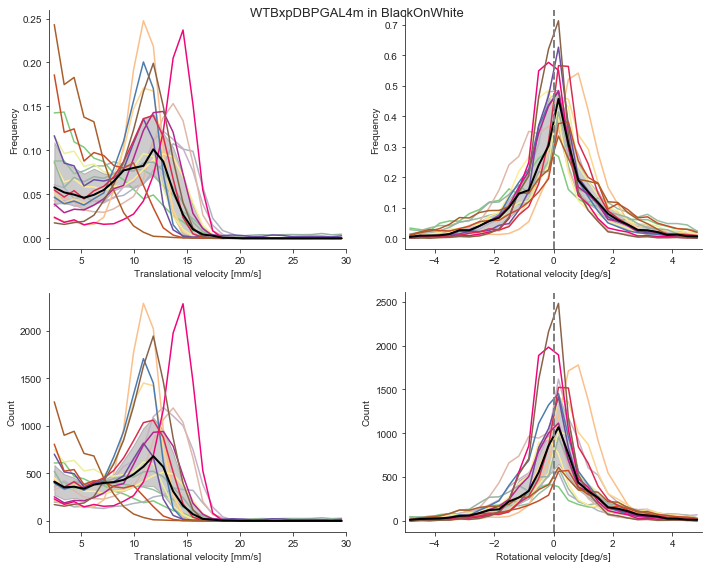

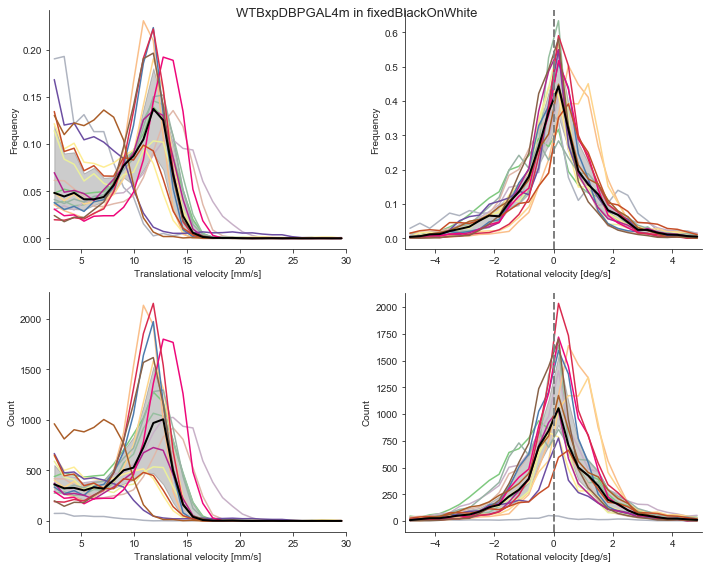

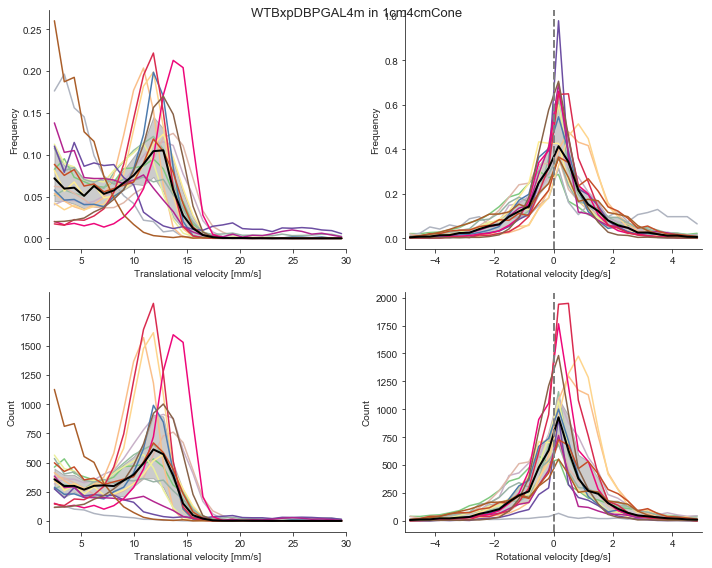

In [142]:
for scene, scenename in enumerate(sceneNames):
    scene_df = FOAllFlies_df.query('sceneName == "' + scenename + '"')
    if scene_df['trialtype'].values[0] == 'plane':
        print(scenename, scene_df['trialtype'].values[0])
        scene_df = scene_df.query('LMdist >= '+str(minLMdist))
        
    titleString = genotypeSex+' in '+ scenename
    
    walkingFig = plotWalkingVelocityDistr(scene_df, flyIDs, flyCMap, histRangeVT, histRangeVR,numBins)
    
    walkingFig.suptitle(titleString, fontsize=13)
    walkingFig.tight_layout()

    walkingFig.savefig(analysisDir + sep + 'velocityTraces' + sep + genotypeSex + '_walingVelocities_'+scenename+\
                       '_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

### Heading angle distribution (if stripe)

In [143]:
try:
    mkdir(analysisDir + sep + 'heading' + sep)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


BlackOnWhite
fixedBlackOnWhite
fly m03 not moving
3.466666666666667
fly m03 not moving
3.466666666666667
1cm4cmCone
fly m03 not moving
6.5476190476190474
fly m03 not moving
6.5476190476190474


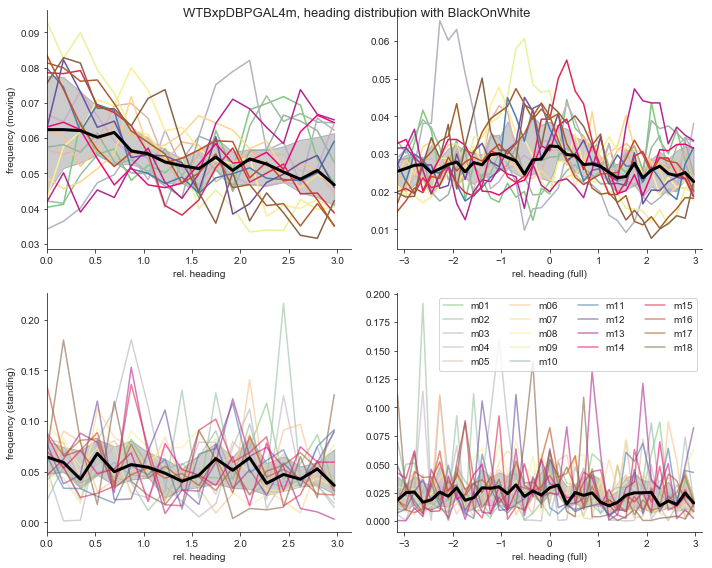

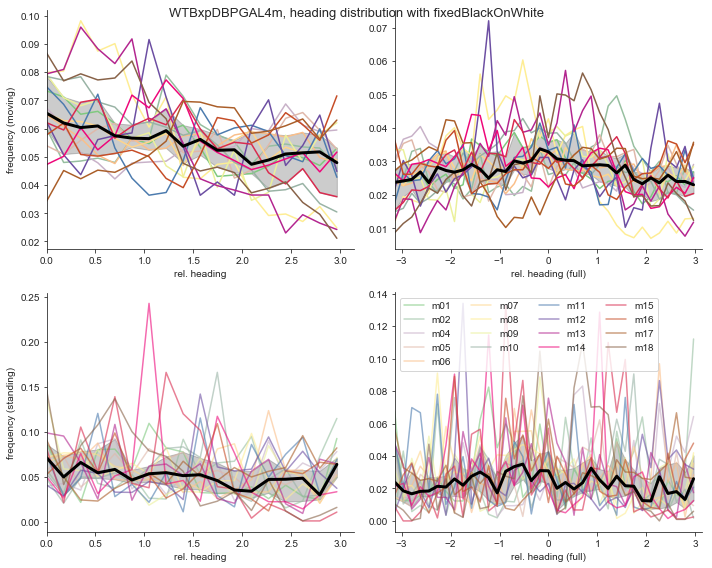

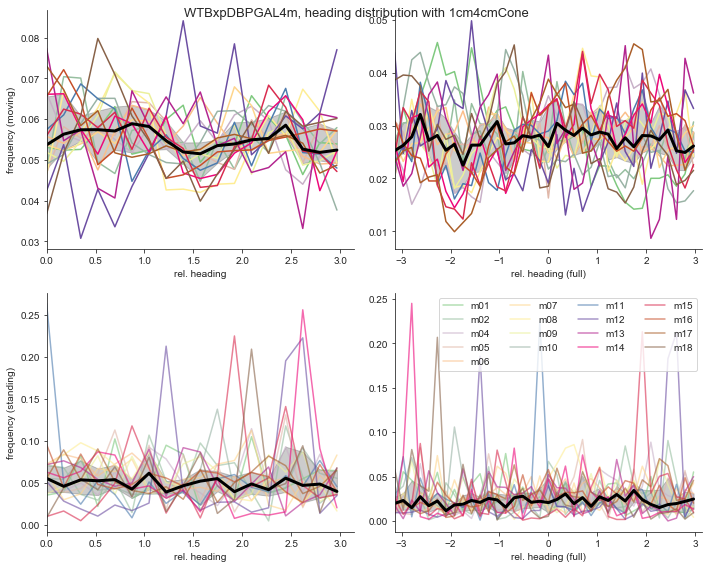

In [144]:
for scene in range(len(sceneNames)):

    scenename = sceneNames[scene]
    print(scenename)
    densityFlag = True
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig, nhead_fullGamma = plotHeadingComparison(FOAllFlies_df, flyIDs, scenename,minLMdist, titleString,
                                                        flyCMap, densityFlag, True)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

BlackOnWhite
fixedBlackOnWhite
fly m03 not moving
3.466666666666667
fly m03 not moving
3.466666666666667
1cm4cmCone
fly m03 not moving
6.5476190476190474
fly m03 not moving
6.5476190476190474


<Figure size 720x576 with 0 Axes>

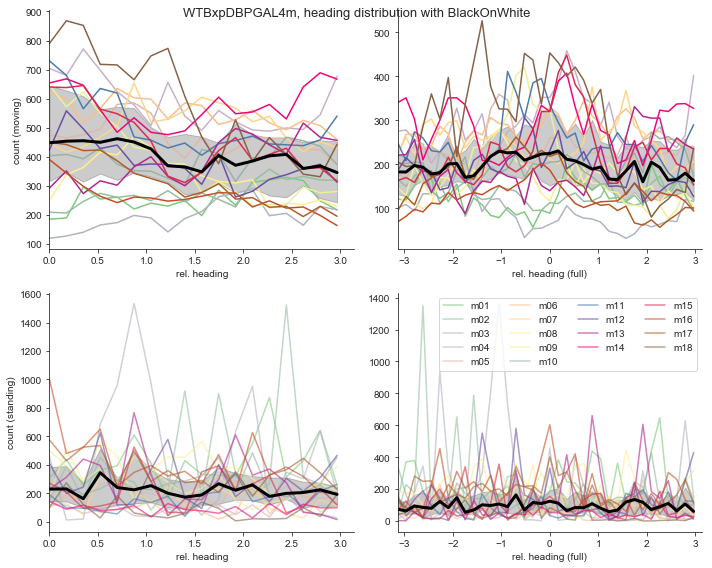

<Figure size 720x576 with 0 Axes>

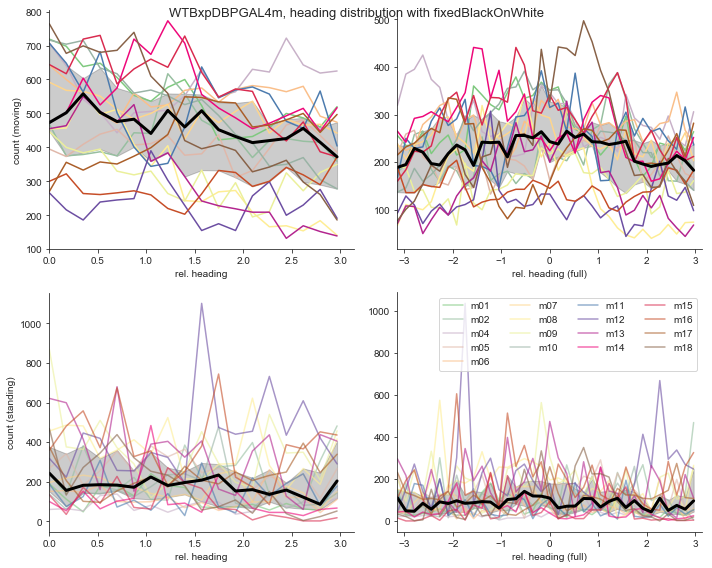

<Figure size 720x576 with 0 Axes>

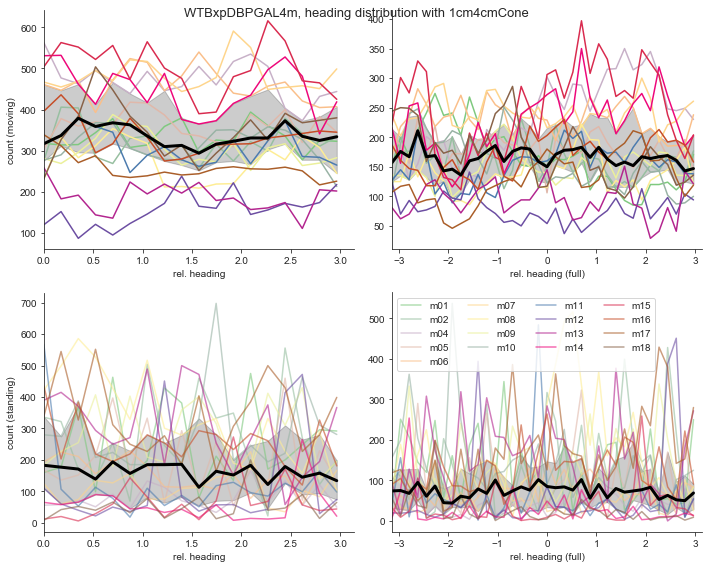

In [145]:
for scene in range(len(sceneNames)):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    print(scenename)
    
    densityFlag = False
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig, nhead_fullGamma = plotHeadingComparison(FOAllFlies_df, flyIDs, scenename,minLMdist,
                                                        titleString, flyCMap, densityFlag, True)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

### Comparison between relative heading and absolute heading in 2D worlds (they are the same in 1D)

BlackOnWhite



<Figure size 720x288 with 0 Axes>

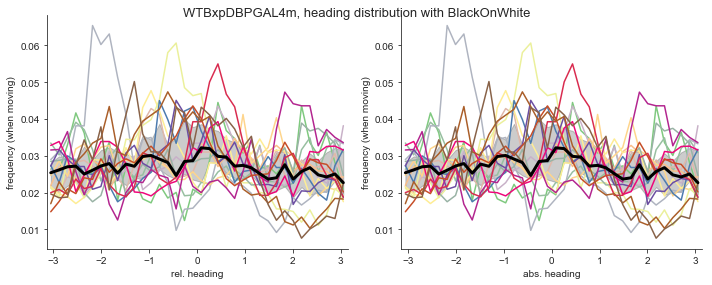

In [146]:
scene = 0
headingfig = plt.figure(figsize=(10,4))

scenename = sceneNames[scene]
print(scenename+'\n')
densityFlag = True
titleString = genotypeSex+', heading distribution with '+ scenename

headingfig = plot2DHeadingComparison(FOAllFlies_df, flyIDs, scenename,minLMdist, titleString, flyCMap, densityFlag, True)

headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_rel-abs-heading_'+scenename+'_medianIQR_n'+str(numFlies)+'.pdf', format = 'pdf')

## Circular statistics on heading distribution
### Helper functions

In [147]:
def polarHeadingPlot(titlestr,ax, r, theta, col, dotsize,alphaval):
    ax.plot(r,theta,'.',markersize=dotsize,color=col,alpha=alphaval)
    ax.set_theta_zero_location('N')
    ax.set_xticklabels(['0','', r'$\frac{\pi}{2}$','', r'$\pi,-\pi$','', r'$-\frac{\pi}{2}$',''],fontsize=12)
    ax.set_rlabel_position(225)
    ax.set_title(titlestr)
    
    
def vMFunc(x, mu, kappa):
    return np.exp(kappa * np.cos(x-mu)) / (2*np.pi*np.i0(kappa))

def vMbiModFunc(x, mu1, mu2, kappa):
    return ( (np.exp(kappa * np.cos(x-mu1)) / (2*np.pi*np.i0(kappa))) + \
            (np.exp(kappa * np.cos(x-mu2)) / (2*np.pi*np.i0(kappa))) )/2

def plotOneTrialHeading(ax1, ax2, gammaful, time, meandir, meanlen):
    ax1.plot(time, gammaful)
    ax1.set_ylim(angleLow, angleHigh)
    ax1.set_xlim(0,600)
    myAxisTheme(ax1)
    
    ax2.plot(meandir, meanlen,'.',markersize=15,color='steelblue',alpha=0.85)
    ax2.set_rlim(0,0.8)
    ax2.set_rlabel_position(180)
    ax2.set_title('heading PVA, ' + sceneName + ', n='+str(numFlies))

### PVA-based analysis

In [148]:
headingPVA = np.nan*np.ones((len(sceneNames),numFlies,2))
anglePVA = np.nan*np.ones((len(sceneNames),numFlies,2))
fliesNotWalking = np.zeros((len(sceneNames)))

for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]
    print('\n'+scenename+'\n')
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + scenename + '") & (flyID =="' + flyIDs[fly] +  '")'
        scene_df = FOAllFlies_df.query(querystring)
        if len(scene_df) == 0: continue
        nTrial = len(scene_df['moving'].squeeze().astype('int').values)
        if scene_df['trialtype'].values[0] == 'plane':
            scene_df = scene_df.query('LMdist > '+str(minLMdist))
        
        moving = scene_df['moving'].squeeze().astype('int').values
        perFlyG = scene_df['gammaFull'].squeeze().astype('float').values
        perFlyA = scene_df['headingAngle'].squeeze().astype('float').values

        if sum(moving)<=0.2*nTrial:
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,nTrial)))
            fliesNotWalking[scene] += 1
            continue
            
        gamFul = perFlyG[moving>0]
        meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

        headingPVA[scene,fly,0] = meandir
        headingPVA[scene,fly,1] = meanlen
        
        angle = perFlyA[moving>0]
        meandir, meanlen = circmeanvec(angle[~np.isnan(angle)],np.ones(len(angle[~np.isnan(angle)])), high=angleHigh, low=angleLow)

        anglePVA[scene,fly,0] = meandir
        anglePVA[scene,fly,1] = meanlen
        
try:
    mkdir(analysisDir + sep + 'circStats' + sep)
except OSError:
    print('Analysis directory already exists.')
        
np.savetxt(analysisDir + 'circStats/'  + genotype + '_headingPVA_dir_'+scenename+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_headingPVA_len_'+scenename+'_n'+ str(numFlies) +'.csv',
           headingPVA[:,:,1], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_anglePVA_dir_'+scenename+'_n'+ str(numFlies) +'.csv',
           anglePVA[:,:,0], delimiter=',')
np.savetxt(analysisDir + 'circStats/'  + genotype + '_anglePVA_len_'+scenename+'_n'+ str(numFlies) +'.csv',
           anglePVA[:,:,1], delimiter=',')


BlackOnWhite


fixedBlackOnWhite

fly m03 not moving: 3.46666666667

1cm4cmCone

fly m03 not moving: 5.775


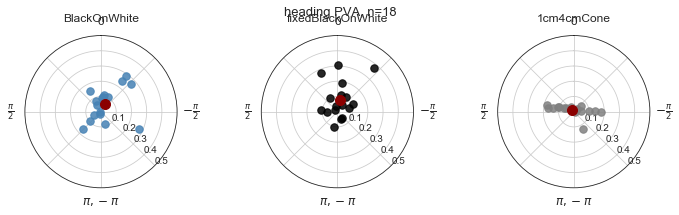

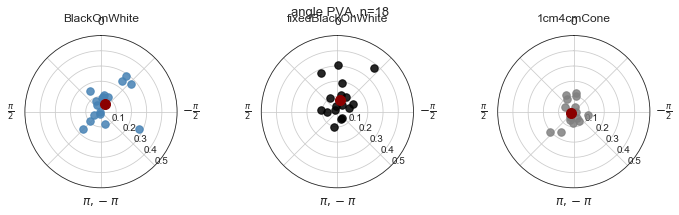

In [149]:
redheadPVAFig = plt.figure(figsize=(10,3))
absheadPVAFig = plt.figure(figsize=(10,3))

for scene in range(len(sceneNames)):
    scenename = sceneNames[scene]    

    ax = redheadPVAFig.add_subplot(1,len(sceneNames),scene+1,projection='polar')
    polarHeadingPlot(scenename,ax, headingPVA[scene,:,0],headingPVA[scene,:,1],trialCol[scene],15,0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,~np.isnan(headingPVA[scene,:,0]),0],\
                                   headingPVA[scene,~np.isnan(headingPVA[scene,:,1]),1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,.5)
    
    ax = absheadPVAFig.add_subplot(1,len(sceneNames),scene+1,projection='polar')
    polarHeadingPlot(scenename,ax, anglePVA[scene,:,0],anglePVA[scene,:,1],trialCol[scene],15,0.85)
    meandir, meanlen = circmeanvec(anglePVA[scene,~np.isnan(anglePVA[scene,:,0]),0],\
                                   anglePVA[scene,~np.isnan(anglePVA[scene,:,1]),1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,.5)


redheadPVAFig.tight_layout()
redheadPVAFig.suptitle('heading PVA, n='+str(numFlies),fontsize=13)
redheadPVAFig.savefig(analysisDir + 'circStats/'  + genotype
                + '_headingPVA_n'+ str(numFlies) +'.pdf', format='pdf') 

absheadPVAFig.tight_layout()
absheadPVAFig.suptitle('angle PVA, n='+str(numFlies),fontsize=13)
absheadPVAFig.savefig(analysisDir + 'circStats/'  + genotype
                + '_anglePVA_n'+ str(numFlies) +'.pdf', format='pdf') 

### Fit von Mises distribution

[0.10857344 0.07836467]


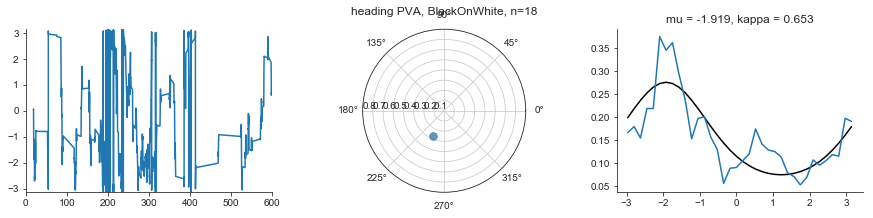

In [150]:
fly = 2
nbins = 37

sceneName = sceneNames[0]
querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
moving = FOAllFlies_df.query(querystring)['moving'].values.squeeze().astype('int')
perFlyG = FOAllFlies_df.query(querystring)['gammaFull'].values.squeeze().astype('float')
perFlyT = FOAllFlies_df.query(querystring)['time'].values.squeeze().astype('float')

if sum(moving)<=0.2*len(moving):
    print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

gamFul = perFlyG[moving>0]
time = perFlyT[moving>0]
meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

bins = np.linspace(angleLow, angleHigh, 37)
x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(gamFul,bins, normed=True)

meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
perr = np.sqrt(np.diag(pcov))
print(perr)

mu = popt[0]
kappa = popt[1]
yhat = vMFunc(x,mu,kappa)

fitFig = plt.figure(figsize=(15,3))
plotOneTrialHeading(fitFig.add_subplot(131),fitFig.add_subplot(132,projection='polar'), gamFul, time, meandir, meanlen)

ax3 = fitFig.add_subplot(133)   
ax3.plot(x,yhat,'k')
ax3.plot(x,n)
ax3.set_title('mu = '+str(round(mu,3))+', kappa = '+str(round(kappa,3)))
myAxisTheme(ax3)

fly m03 not moving: 7.40833333333
[1.76484695e+04 1.76484694e+04 5.06932334e-01]


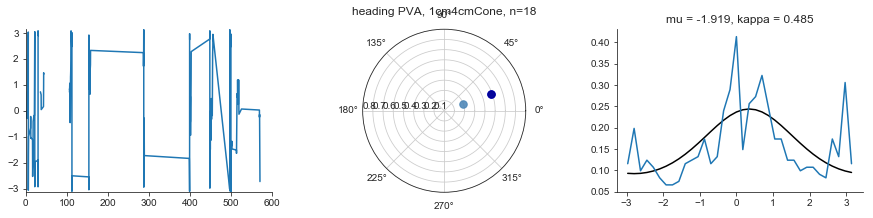

In [151]:
sceneName = sceneNames[2]
fly = 2

querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
moving = FOAllFlies_df.query(querystring)['moving'].values.squeeze().astype('int')
perFlyG = FOAllFlies_df.query(querystring)['gammaFull'].values.squeeze().astype('float')
perFlyT = FOAllFlies_df.query(querystring)['time'].values.squeeze().astype('float')

if sum(moving)<=0.2*len(moving):
    print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

gamFul = perFlyG[moving>0]
time = perFlyT[moving>0]
meandir, meanlen = circmeanvec(gamFul[~np.isnan(gamFul)],np.ones(len(gamFul[~np.isnan(gamFul)])), high=angleHigh, low=angleLow)

bins = np.linspace(angleLow, angleHigh, nbins)
x = bins[:-1] + np.mean(np.diff(bins))
[n,edg] = np.histogram(gamFul,bins = nbins-1, range=(angleLow, angleHigh), normed=True)

meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

popt, pcov = curve_fit(vMbiModFunc, x, n , p0=[-np.pi/2, np.pi/2, meanlen_freq], bounds=([-np.pi, -np.pi, 0], [np.pi, np.pi, np.inf]))
perr = np.sqrt(np.diag(pcov))
print(perr)

mu1 = popt[0]
mu2 = popt[1]
kappa = popt[2]

yhat = vMbiModFunc(x, mu1, mu2, kappa)

fitFig = plt.figure(figsize=(15,3))
ax1 = fitFig.add_subplot(131)
ax2 = fitFig.add_subplot(132,projection='polar')
plotOneTrialHeading(ax1, ax2, gamFul, time, meandir, meanlen)

ax2.plot(mu1, kappa,'.',markersize=15,color='blue',alpha=0.85)
ax2.plot(mu2, kappa,'.',markersize=15,color='darkblue',alpha=0.85)

ax3 = fitFig.add_subplot(133)
ax3.plot(x,yhat,'k')
ax3.plot(x,n)
ax3.set_title('mu = '+str(round(mu,3))+', kappa = '+str(round(kappa,3)))
myAxisTheme(ax3)

### Fit unimodal von Mises

fly m03 not moving: 3.46666666667
fly m03 not moving: 7.40833333333


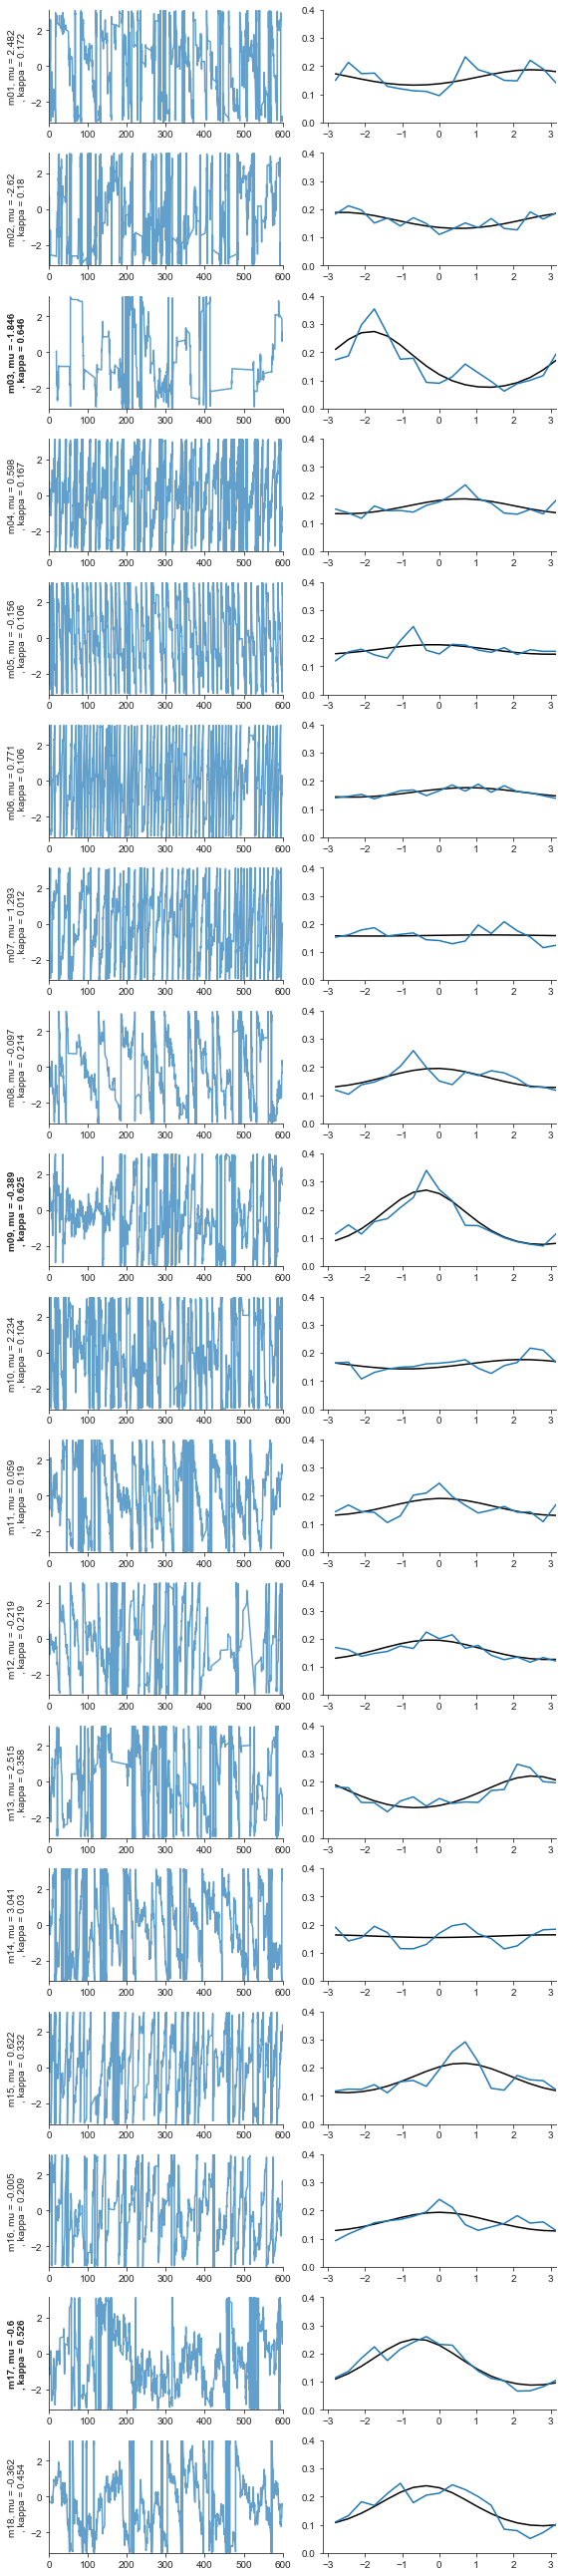

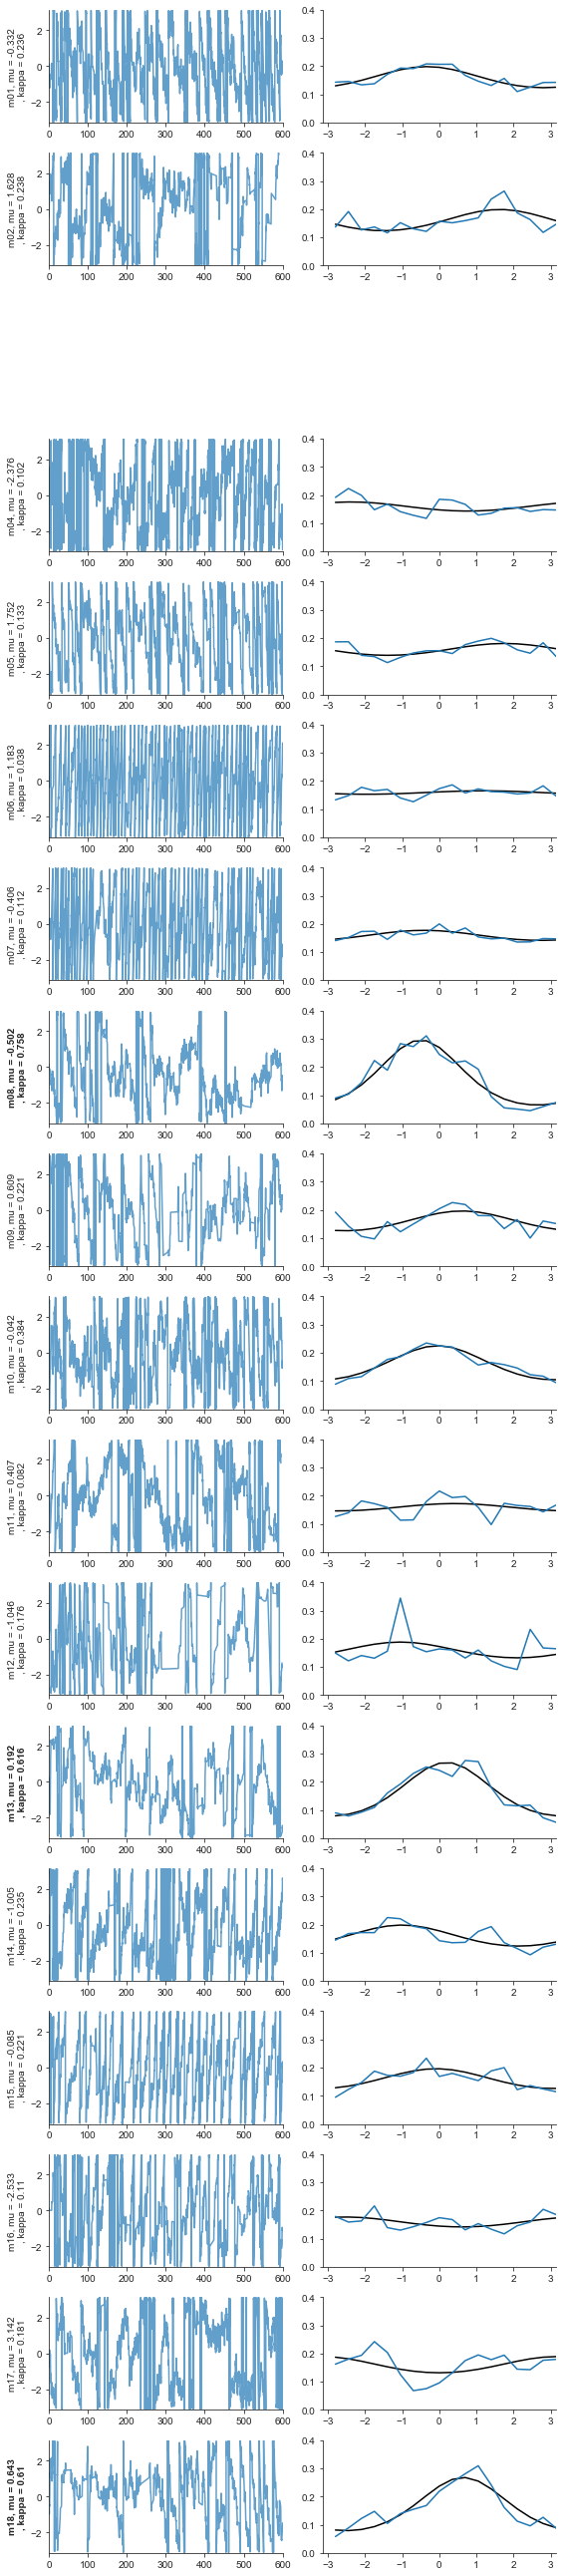

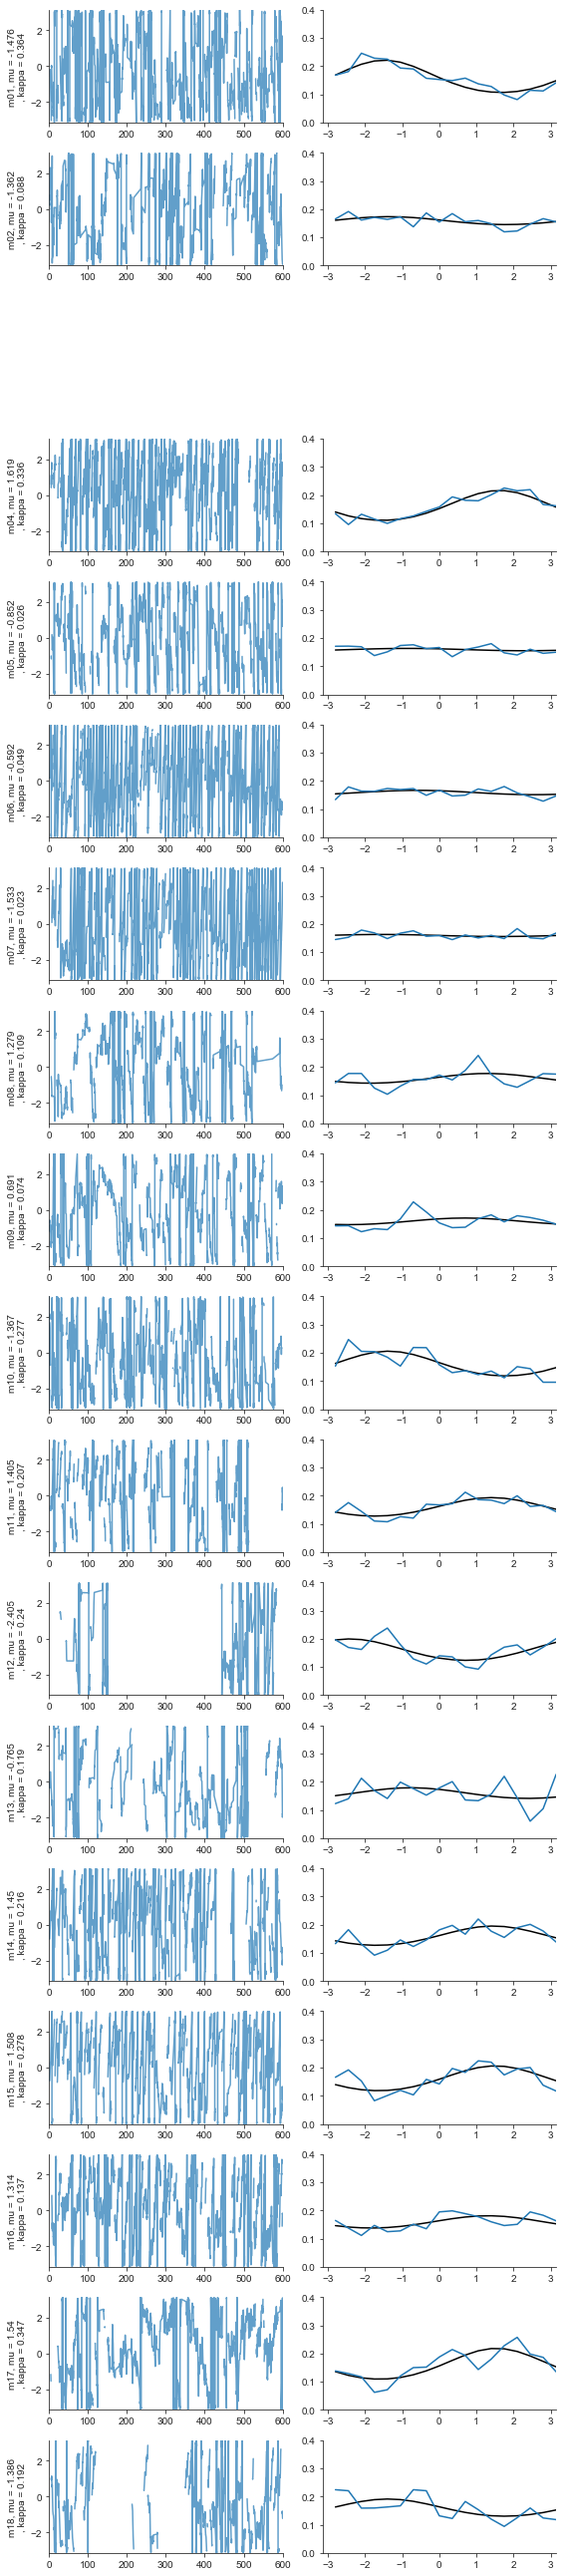

In [152]:
#bins size
binwidth = 20 #deg
vmfits = np.nan*np.ones((len(sceneNames),5,numFlies))

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(8,2*numFlies))
    
    for fly in range(numFlies):
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
        scene_df = FOAllFlies_df.query(querystring)
        if scene_df['trialtype'].values[0] == 'plane':
            scene_df = scene_df.query('LMdist > '+str(minLMdist)+' or LMdist == "NaN"')
        moving = scene_df['moving'].values.squeeze().astype('int')
        perFlyG = scene_df['gammaFull'].values.squeeze().astype('float')
        perFlyT = scene_df['time'].values.squeeze().astype('float')
        
        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

            continue

        gamFul = perFlyG[moving>0]
        time = perFlyT[moving>0]
        
        bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
        x = bins[:-1] + np.mean(np.diff(bins))
        [n,edg] = np.histogram(gamFul,bins=(360/binwidth), range=(angleLow,angleHigh), normed=True)
        meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

        popt, pcov = curve_fit(vMFunc, x, n, p0=[meandir_freq, meanlen_freq], bounds=([-np.pi, 0], [np.pi, np.inf]))
        mu = popt[0]
        kappa = popt[1]
        yhat = vMFunc(x,mu,kappa)

        #compute kolmogorov-smirnov statistic as measure of goodness of fit
        [ks, p] = sts.ks_2samp(n, yhat)

        #compute squared difference from fit
        sqd = np.sum(np.square(n-yhat))

        vmfits[scene,0,fly] = mu
        vmfits[scene,1,fly] = kappa
        vmfits[scene,2,fly] = sqd
        vmfits[scene,3,fly] = p
        vmfits[scene,4,fly] = ks

        #plot fit results
        ax = fitFig.add_subplot(numFlies,2,1+fly*2)
        ax.plot(time, gamFul,alpha=0.7)
        ax.set_xlim(0,600)
        ax.set_ylim(angleLow,angleHigh)
        if(kappa>kappaTH):
            ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)),   fontweight = 'bold')
        else:
            ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))

        myAxisTheme(ax)

        ax = fitFig.add_subplot(numFlies,2,2+fly*2)
        ax.plot(x,yhat,'k')
        ax.plot(x,n)
        ax.set_ylim(0,0.4)
        ax.set_xlim(angleLow,angleHigh)
        myAxisTheme(ax)

    fitFig.tight_layout()

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFit_n'+ str(numFlies) +'.pdf', format='pdf') 

BlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m07', 'm14']
flies with large summed squared error:
[]
fixedBlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m06']
flies with large summed squared error:
[]


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less_equal
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in greater_equal


1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m05', 'm06', 'm07', 'm09', 'm13']
flies with large summed squared error:
[]


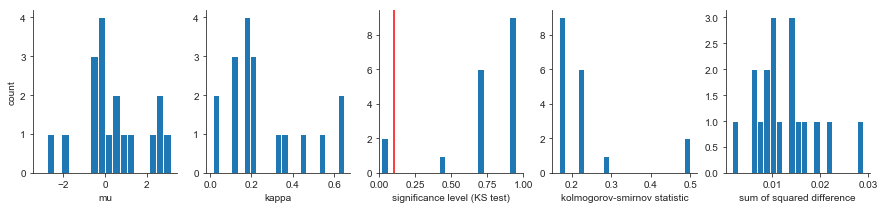

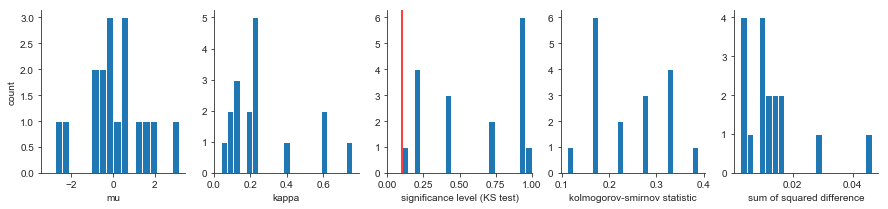

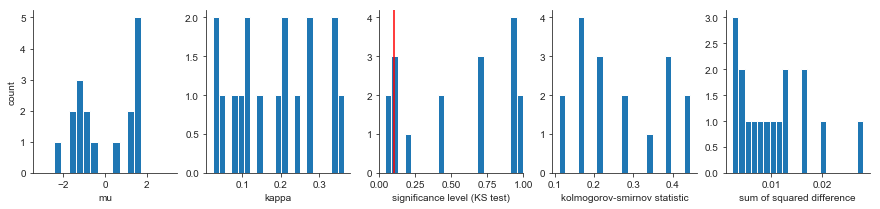

In [153]:
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(15,3))

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    muax = fitFig.add_subplot(151)
    muax.hist(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins)
    #muax.set_xlim(-np.pi, np.pi)
    muax.set_ylabel('count')
    muax.set_xlabel('mu')
    myAxisTheme(muax)

    bins = np.linspace(0, 2, 21)
    kapax = fitFig.add_subplot(152)
    kapax.hist(vmfits[scene,1,~np.isnan(vmfits[scene,1,:])],len(bins))
    #kapax.set_xlim(0, 2)
    kapax.set_xlabel('kappa')
    myAxisTheme(kapax)

    bins = np.linspace(0, 1, 21)
    pax = fitFig.add_subplot(153)
    pax.hist(vmfits[scene,3,~np.isnan(vmfits[scene,3,:])],len(bins))
    pax.set_xlim(0, 1)
    pax.axvline(0.1,color='red')
    pax.set_xlabel('significance level (KS test)')

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(154)
    ksax.hist(vmfits[scene,4,~np.isnan(vmfits[scene,4,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('kolmogorov-smirnov statistic')
    myAxisTheme(ksax)

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(155)
    ksax.hist(vmfits[scene,2,~np.isnan(vmfits[scene,2,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('sum of squared difference')
    myAxisTheme(ksax)

    print(sceneName)
    print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
    print([flyIDs[fly] for fly in np.where(vmfits[scene,3,:]<=0.1)[0]])

    print('flies with large summed squared error:')
    print([flyIDs[fly] for fly in np.where(vmfits[scene,2,:]>=0.08)[0]])

    myAxisTheme(pax)

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


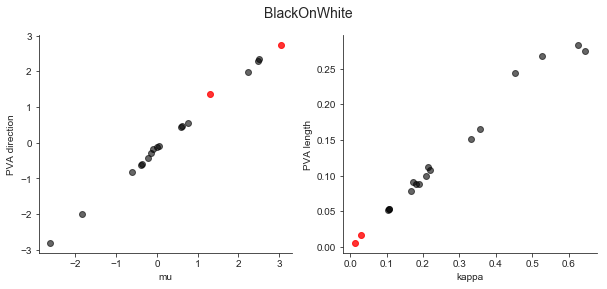

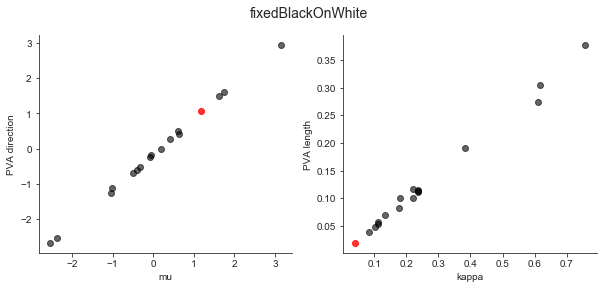

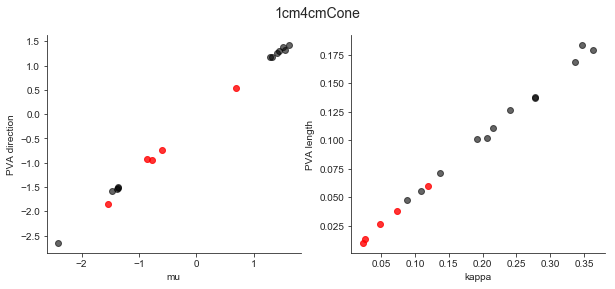

In [154]:
# Correlation between von Mieses fit and PVA
#Plot fit results
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    corrFig = plt.figure(figsize=(10,4))
    corrFig.suptitle(sceneName,fontsize=14)

    notFit = np.logical_and(np.logical_and(vmfits[scene,3,:]<=0.1, headingPVA[scene,:,1]<0.5),\
                            ~np.isnan(headingPVA[scene,:,1]))

    #correlation between mu and PVA direction
    muax = corrFig.add_subplot(121)
    muax.plot(vmfits[scene,0,~notFit],headingPVA[scene,~notFit,0],'ko',alpha=0.6)
    muax.plot(vmfits[scene,0,notFit],headingPVA[scene,notFit,0],'ro',alpha=0.8)
    muax.set_xlabel('mu'); muax.set_ylabel('PVA direction');
    myAxisTheme(muax)

    #correlation between kappa and PVA length
    kapax = corrFig.add_subplot(122)
    kapax.plot(vmfits[scene,1,~notFit],headingPVA[scene,~notFit,1],'ko',alpha=0.6)
    kapax.plot(vmfits[scene,1,notFit],headingPVA[scene,notFit,1],'ro',alpha=0.8)
    kapax.set_xlabel('kappa'); kapax.set_ylabel('PVA length');
    myAxisTheme(kapax)

    corrFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vM-vs-PVA_n'+ str(numFlies) +'.pdf', format='pdf') 

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater


problem with sample
nan
problem with sample
nan


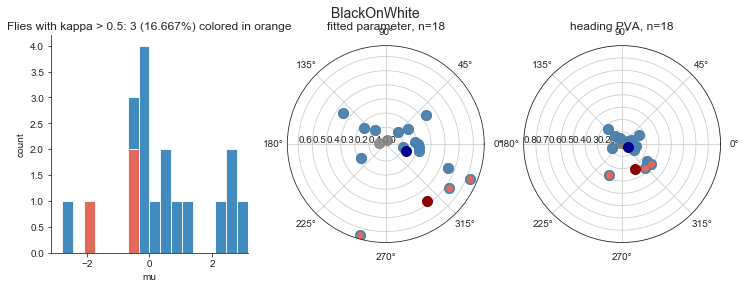

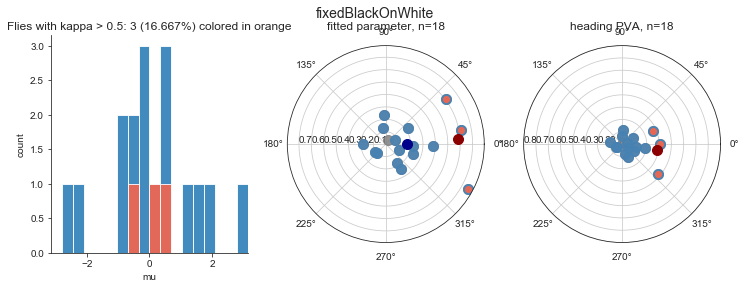

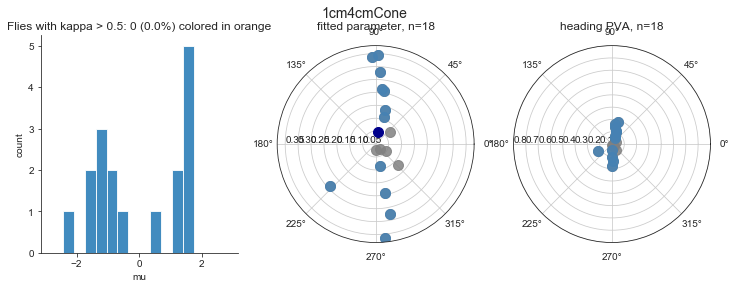

In [155]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))

    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    x = bins[:-1] + np.mean(np.diff(bins))
    [n,edg] = np.histogram(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins)
    [n_slct,edg] = np.histogram(vmfits[scene,0,slct],bins)

    #Plot fit results
    fixFig = plt.figure(figsize=(12,4))
    fixFig.suptitle(sceneName,fontsize=14)

    #histogram of fitted location (mu)
    muax = fixFig.add_subplot(131)
    muax.hist(vmfits[scene,0,~np.isnan(vmfits[scene,0,:])],bins,alpha=0.85)
    muax.hist(vmfits[scene,0,slct],bins,color='tomato',alpha=0.85)
    muax.set_xlim(-np.pi, np.pi)
    muax.set_xlabel('mu')
    muax.set_ylabel('count')
    muax.set_title('Flies with kappa > '+str(kappaTH)+': '+str(sum(vmfits[scene,1,:]>kappaTH))+' ('+\
                   str(round(100.0*sum(vmfits[scene,1,:]>kappaTH)/float(numFlies),3))+'%) colored in orange')
    myAxisTheme(muax)
    
    #polar plot of fitted location and shape parameter
    ax = fixFig.add_subplot(132,projection='polar')
    ax.plot(vmfits[scene,0,:],vmfits[scene,1,:],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    #ax.set_rlim(0,1)
    ax.set_rlabel_position(180)
    ax.set_title('fitted parameter, n='+str(numFlies))

    #polar plot of PVA
    ax = fixFig.add_subplot(133,projection='polar')
    ax.plot(headingPVA[scene,:,0],headingPVA[scene,:,1],'o',markersize=10,color='grey',alpha=0.85)
    ax.plot(headingPVA[scene,goodFit,0],headingPVA[scene,goodFit,1],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,:,0],headingPVA[scene,:,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)

    ax.plot(headingPVA[scene,slct,0],headingPVA[scene,slct,1],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,slct,0],headingPVA[scene,slct,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,0.8)
    ax.set_rlabel_position(180)
    ax.set_title('heading PVA, n='+str(numFlies))
    
    #fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMFixation_n'+ str(numFlies) +'.pdf', format='pdf') 

### Fit bimodal von Mises to those distributions for which no good unimodal fit was found

BlackOnWhite
m07
m14
fixedBlackOnWhite
m06


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


1cm4cmCone
m05
m06
m07
m09
m13


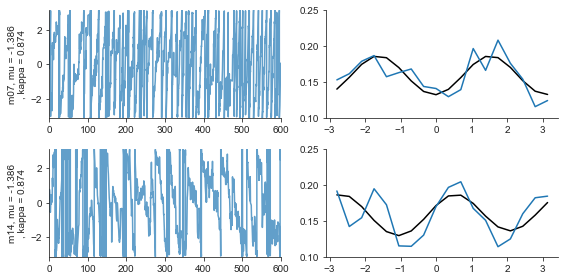

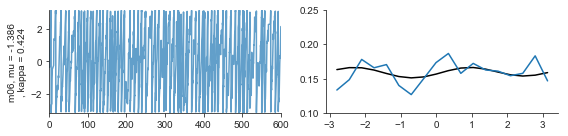

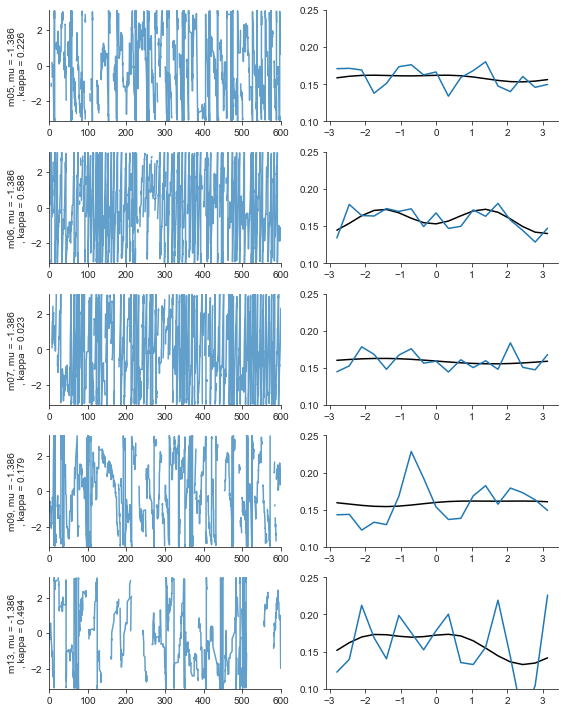

In [156]:
#bins size
binwidth = 20 #deg
vmbmfits = np.nan*np.ones((len(sceneNames),6,numFlies))

for scene, sceneName in enumerate(sceneNames):
    print(sceneName)
    
    noFit = np.logical_and(np.logical_and(vmfits[scene,3,:]<=0.1, headingPVA[scene,:,1]<0.5),\
                             ~np.isnan(headingPVA[scene,:,1]))
    
    notGoodFit = np.where(noFit>0)[0]
    
    if(len(notGoodFit)==0):
        continue
    
    fitFig = plt.figure(figsize=(8,2*len(notGoodFit)))
    
    for ind, fly in enumerate(notGoodFit):
        print(flyIDs[fly])
        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'
        scene_df = FOAllFlies_df.query(querystring)
        if scene_df['trialtype'].values[0] == 'plane':
            scene_df = scene_df.query('LMdist > '+str(minLMdist)+' or LMdist == "NaN"')
        moving = scene_df['moving'].values.squeeze().astype('int')
        perFlyG = scene_df['gammaFull'].values.squeeze().astype('float')
        perFlyT = scene_df['time'].values.squeeze().astype('float')

        if sum(moving)<=0.2*len(moving):
            print('fly '+str(flyIDs[fly])+' not moving: '+str(100.0*sum(moving)/max(1,len(moving))))

            continue

        gamFul = perFlyG[moving>0]
        time = perFlyT[moving>0]

        bins = np.linspace(angleLow,angleHigh, 360/binwidth + 1)
        x = bins[:-1] + np.mean(np.diff(bins))
        [n,edg] = np.histogram(gamFul,bins = 360/binwidth, range=(angleLow,angleHigh), normed=True)
        meandir_freq, meanlen_freq = circmeanvec(n,np.ones(len(n)), high=angleHigh, low=angleLow)

        mu01 = np.nanmax(n)
        mu02 = np.mod(mu01+2*np.pi,2*np.pi)-np.pi
        
        popt, pcov = curve_fit(vMbiModFunc, x, n, p0=[mu01,mu02,meanlen_freq],\
                               bounds=([-np.pi, -np.pi, 0], [np.pi, np.pi, np.inf]))
        mu1 = popt[0]
        mu2 = popt[1]
        kappa = popt[2]
        yhat = vMbiModFunc(x,mu1,mu2,kappa)

        #compute kolmogorov-smirnov statistic as measure of goodness of fit
        [ks, p] = sts.ks_2samp(n, yhat)

        #compute squared difference from fit
        sqd = np.sum(np.square(n-yhat))

        vmbmfits[scene,0,fly] = mu1
        vmbmfits[scene,1,fly] = mu2
        vmbmfits[scene,2,fly] = kappa
        vmbmfits[scene,3,fly] = sqd
        vmbmfits[scene,4,fly] = p
        vmbmfits[scene,5,fly] = ks

        #plot fit results
        ax = fitFig.add_subplot(len(notGoodFit),2,1+ind*2)
        ax.plot(time, gamFul,alpha=0.7)
        ax.set_xlim(0,600)
        ax.set_ylim(angleLow,angleHigh)
        ax.set_ylabel(str(flyIDs[fly])+', mu = '+str(round(mu,3)) +'\n, kappa = '+str(round(kappa,3)))
        myAxisTheme(ax)

        ax = fitFig.add_subplot(len(notGoodFit),2,2+ind*2)
        ax.plot(x,yhat,'k')
        ax.plot(x,n)
        ax.set_ylim(angleLow,angleHigh)
        ax.set_ylim(0.1,0.25)
        myAxisTheme(ax)

        fitFig.tight_layout()

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMbiModFit_n'+ str(numFlies) +'.pdf', format='pdf') 

BlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
[]


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less_equal


fixedBlackOnWhite
flies with heading distribution that is significantly different from von Mieses fit (KS test):
[]
1cm4cmCone
flies with heading distribution that is significantly different from von Mieses fit (KS test):
['m05', 'm07', 'm09', 'm13']


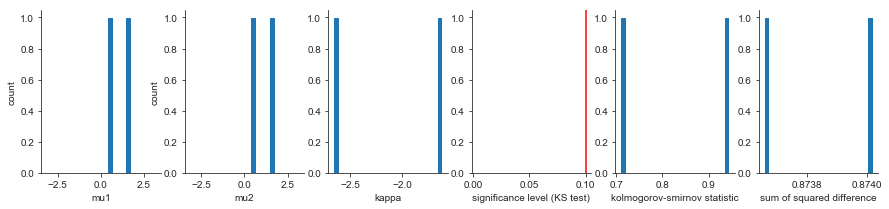

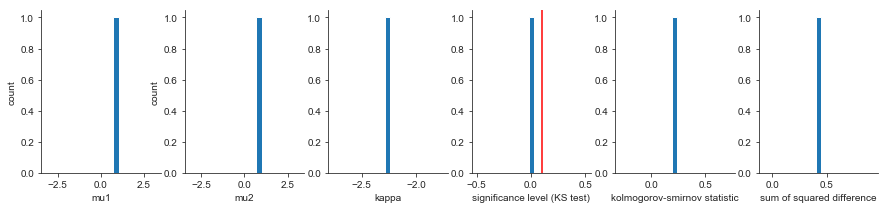

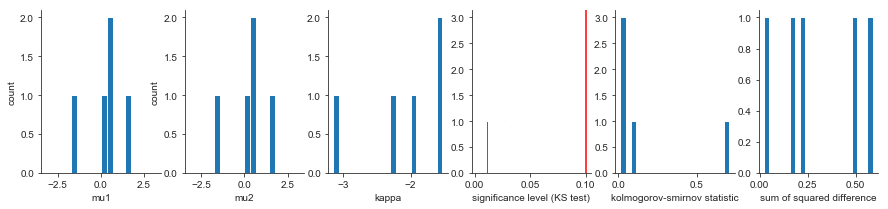

In [157]:
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    fitFig = plt.figure(figsize=(15,3))

    bins = np.linspace(-np.pi, np.pi, 360/binwidth + 1)

    muax = fitFig.add_subplot(161)
    muax.hist(vmbmfits[scene,0,~np.isnan(vmbmfits[scene,0,:])],bins)
    muax.set_ylabel('count')
    muax.set_xlabel('mu1')
    myAxisTheme(muax)
    
    muax = fitFig.add_subplot(162)
    muax.hist(vmbmfits[scene,0,~np.isnan(vmbmfits[scene,1,:])],bins)
    muax.set_ylabel('count')
    muax.set_xlabel('mu2')
    myAxisTheme(muax)

    bins = np.linspace(0, 2, 21)
    kapax = fitFig.add_subplot(163)
    kapax.hist(vmbmfits[scene,1,~np.isnan(vmbmfits[scene,2,:])],len(bins))
    kapax.set_xlabel('kappa')
    myAxisTheme(kapax)

    bins = np.linspace(0, 1, 21)
    pax = fitFig.add_subplot(164)
    pax.hist(vmbmfits[scene,3,~np.isnan(vmbmfits[scene,4,:])],len(bins))
    #pax.set_xlim(0, 1)
    pax.axvline(0.1,color='red')
    pax.set_xlabel('significance level (KS test)')

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(165)
    ksax.hist(vmbmfits[scene,4,~np.isnan(vmbmfits[scene,5,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('kolmogorov-smirnov statistic')
    myAxisTheme(ksax)

    bins = np.linspace(0, 1, 21)
    ksax = fitFig.add_subplot(166)
    ksax.hist(vmbmfits[scene,2,~np.isnan(vmbmfits[scene,3,:])],len(bins))
    #ksax.set_xlim(0, 1)
    ksax.set_xlabel('sum of squared difference')
    myAxisTheme(ksax)

    print(sceneName)
    print('flies with heading distribution that is significantly different from von Mieses fit (KS test):')
    print([flyIDs[fly] for fly in np.where(vmbmfits[scene,4,:]<=0.1)[0]])

    myAxisTheme(pax)

    fitFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMbiModFitDistributions_n'+ str(numFlies) +'.pdf', format='pdf') 

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


problem with sample
nan
problem with sample
nan


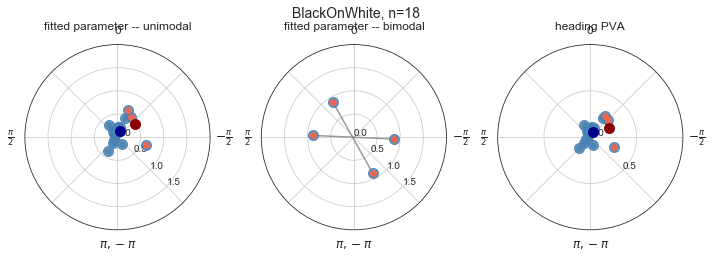

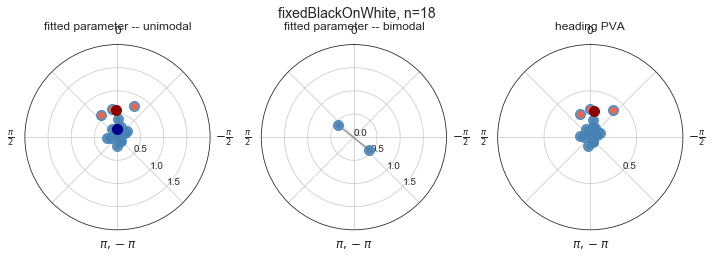

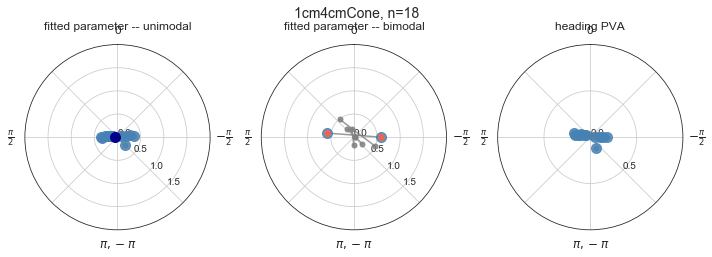

In [158]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

rlims = [2,2,2,3]
for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)

    #Plot fit results
    fixFig = plt.figure(figsize=(10,3.75))
    fixFig.suptitle(sceneName+', n='+str(numFlies),fontsize=14)

    #polar plot of fitted location and shape parameter - unimodal
    ax = fixFig.add_subplot(131,projection='polar')
    polarHeadingPlot('fitted parameter -- unimodal',ax, vmfits[scene,0,:],vmfits[scene,1,:],'grey',10,0.85)
    ax.plot(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,goodFit],vmfits[scene,1,goodFit], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,rlims[scene])
    ax.set_yticks(np.linspace(0,rlims[scene], 2*rlims[scene], endpoint=False))
    
    #polar plot of fitted location and shape parameter - bimodal
    ax = fixFig.add_subplot(132,projection='polar')
    polarHeadingPlot('fitted parameter -- bimodal',ax, vmbmfits[scene,0,:],vmbmfits[scene,2,:],'grey',10,0.85)
    ax.plot(vmbmfits[scene,1,:],vmbmfits[scene,2,:],'.',markersize=10,color='grey',alpha=0.85)
    ax.plot([vmbmfits[scene,0,:],vmbmfits[scene,1,:]],[vmbmfits[scene,2,:],vmbmfits[scene,2,:]],'-',color='grey',alpha=0.8)
    ax.plot(vmbmfits[scene,0,goodFit_bm],vmbmfits[scene,2,goodFit_bm],'o',markersize=10,color='steelblue',alpha=0.85)
    ax.plot(vmbmfits[scene,1,goodFit_bm],vmbmfits[scene,2,goodFit_bm],'o',markersize=10,color='steelblue',alpha=0.85)
    ax.plot(vmbmfits[scene,0,slct_bm],vmbmfits[scene,2,slct_bm],'.',markersize=12,color='tomato',alpha=0.85)
    ax.plot(vmbmfits[scene,1,slct_bm],vmbmfits[scene,2,slct_bm],'.',markersize=12,color='tomato',alpha=0.85)
    ax.set_rlim(0,rlims[scene])
    ax.set_yticks(np.linspace(0,rlims[scene], 2*rlims[scene], endpoint=False))
    
    #polar plot of PVA
    ax = fixFig.add_subplot(133,projection='polar')
    polarHeadingPlot('heading PVA',ax, headingPVA[scene,:,0],headingPVA[scene,:,1],'grey',10,0.85)
    ax.plot(headingPVA[scene,goodFit,0],headingPVA[scene,goodFit,1],'o',markersize=10,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,:,0],headingPVA[scene,:,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkblue',alpha=1, markersize=10)
    ax.plot(headingPVA[scene,slct,0],headingPVA[scene,slct,1],'.',markersize=12,color='tomato',alpha=0.85)
    meandir, meanlen = circmeanvec(headingPVA[scene,slct,0],headingPVA[scene,slct,1], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'o', color='darkred',alpha=1, markersize=10)
    ax.set_rlim(0,1)
    ax.set_yticks(np.linspace(0,1, 2, endpoint=False))
    
    fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMBiModFixation_n'+ str(numFlies) +'.pdf', format='pdf') 
    
    np.savetxt(analysisDir + 'circStats/'  + genotype + '_vMFixation_'+sceneName+'_n'+ str(numFlies) +'.csv',
           np.c_[vmfits[scene,0,:],vmfits[scene,1,:],goodFit,
            vmbmfits[scene,0,:],vmbmfits[scene,1,:],vmbmfits[scene,2,:],goodFit_bm],
            delimiter=',', header='mu,kappa,gof,mu1_bm,mu2_bm,kappa_bm,gof_bm')
    

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


problem with sample
nan


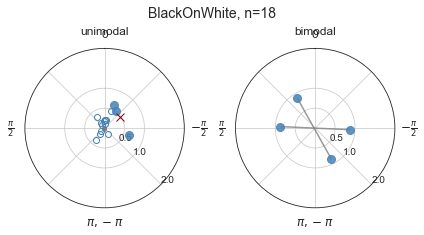

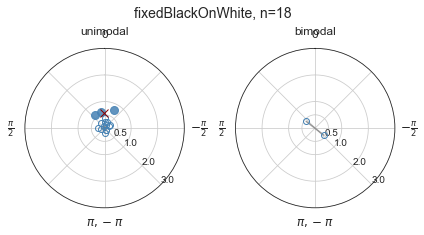

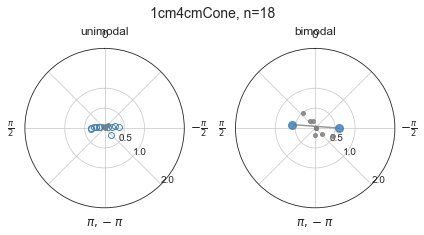

In [159]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

sceneYLim = [2,3,2,3]

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    gfplt = np.logical_and(goodFit, ~slct)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)
    gfplt_bm = np.logical_and(goodFit_bm, ~slct_bm)

    #Plot fit results
    fixFig = plt.figure(figsize=(6,3.5))
    fixFig.suptitle(sceneName+', n='+str(numFlies),fontsize=14)

    #polar plot of fitted location and shape parameter - unimodal
    ax = fixFig.add_subplot(121,projection='polar')
    polarHeadingPlot('unimodal',ax,vmfits[scene,0,~goodFit],vmfits[scene,1,~goodFit],'grey',8,0.85)
    ax.plot(vmfits[scene,0,gfplt],vmfits[scene,1,gfplt],'o',markeredgecolor='steelblue',
            markerfacecolor='none',  markeredgewidth=1, markersize=6)
    ax.plot(vmfits[scene,0,slct],vmfits[scene,1,slct],'o',markersize=8,color='steelblue',alpha=0.85)
    meandir, meanlen = circmeanvec(vmfits[scene,0,slct],vmfits[scene,1,slct], high=angleHigh, low=angleLow)
    ax.plot(meandir,meanlen,'x', color='darkred',alpha=1, markersize=8)
    ax.set_yticks([0.5, 1, 2, 3])
    ax.set_ylim(0, sceneYLim[scene])
    
    #polar plot of fitted location and shape parameter - bimodal
    ax = fixFig.add_subplot(122,projection='polar')
    polarHeadingPlot('bimodal',ax,vmbmfits[scene,0,~goodFit_bm],vmbmfits[scene,2,~goodFit_bm],'grey',8,0.85)
    ax.plot(vmbmfits[scene,1,~goodFit_bm],vmbmfits[scene,2,~goodFit_bm],'.',markersize=8,color='grey',alpha=0.85)
    ax.plot([vmbmfits[scene,0,goodFit_bm],vmbmfits[scene,1,goodFit_bm]],
            [vmbmfits[scene,2,goodFit_bm],vmbmfits[scene,2,goodFit_bm]],'-',color='grey',alpha=0.8)
    ax.plot(vmbmfits[scene,0,gfplt_bm],vmbmfits[scene,2,gfplt_bm],'o',color='steelblue',markerfacecolor='none', 
            markeredgewidth=1, markersize=6)
    ax.plot(vmbmfits[scene,1,gfplt_bm],vmbmfits[scene,2,gfplt_bm],'o',color='steelblue',markerfacecolor='none', 
            markeredgewidth=1, markersize=6)
    ax.plot(vmbmfits[scene,0,slct_bm],vmbmfits[scene,2,slct_bm],'o',markersize=8,color='steelblue',alpha=0.85)
    ax.plot(vmbmfits[scene,1,slct_bm],vmbmfits[scene,2,slct_bm],'o',markersize=8,color='steelblue',alpha=0.85)
    ax.set_yticks([0.5, 1, 2, 3])
    ax.set_ylim(0, sceneYLim[scene])
    
    fixFig.tight_layout()
    fixFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + sceneName
                   + '_vMBiModFixation_n'+ str(numFlies) +'.pdf', format='pdf') 

### Selection of data

In [160]:
print('Total number of flies measured: ' + str(numFlies))

for scene,sceneName in enumerate(sceneNames):
    print('\n'+sceneName)
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)
    
    print('Number of flies that walked for less than 20% of trial time: ' + str(int(fliesNotWalking[scene])) \
          + ' ('+str(numFlies)+')')
    
    print('Unimodal fits:')
    print('  Number of walking flies for which von Mises was good fit: ' + str(sum(goodFit))\
          + ' ('+str(numFlies-int(fliesNotWalking[scene]))+')')
    print('  Total number of fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmfits[scene,1,:]>kappaTH)) + ' ('+str(numFlies-int(fliesNotWalking[scene]))+')')
    print('  Number of well fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmfits[scene,1,goodFit]>kappaTH)) + ' ('+str(sum(goodFit))+')')

    print('Bimodal fits:')
    print('  Number of walking flies for which bimodal von Mises was good fit: ' + str(sum(goodFit_bm))\
          + ' ('+str(sum(~goodFit)-int(fliesNotWalking[scene]))+')')
    print('  Number of well fitted distributions with concentration measure kappa > '+str(kappaTH)+': '\
          +str(sum(vmbmfits[scene,2,goodFit_bm]>kappaTH)) + ' ('+str(sum(goodFit_bm))+')')

Total number of flies measured: 18

BlackOnWhite
Number of flies that walked for less than 20% of trial time: 0 (18)
Unimodal fits:
  Number of walking flies for which von Mises was good fit: 16 (18)
  Total number of fitted distributions with concentration measure kappa > 0.5: 3 (18)
  Number of well fitted distributions with concentration measure kappa > 0.5: 3 (16)
Bimodal fits:
  Number of walking flies for which bimodal von Mises was good fit: 2 (2)
  Number of well fitted distributions with concentration measure kappa > 0.5: 2 (2)

fixedBlackOnWhite
Number of flies that walked for less than 20% of trial time: 1 (18)
Unimodal fits:
  Number of walking flies for which von Mises was good fit: 16 (17)
  Total number of fitted distributions with concentration measure kappa > 0.5: 3 (17)
  Number of well fitted distributions with concentration measure kappa > 0.5: 3 (16)
Bimodal fits:
  Number of walking flies for which bimodal von Mises was good fit: 1 (1)
  Number of well fitted dist

/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater


### Visualise performance with bar plot

BlackOnWhite
fixedBlackOnWhite
1cm4cmCone


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in greater
  if sys.path[0] == '':


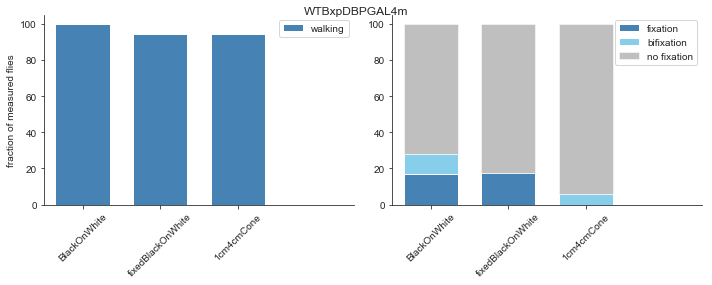

In [161]:
fixBarFig, ax  = plt.subplots(1, 2, figsize=(10,4))
width = 0.7
permSceneNames = [sceneNames[1],sceneNames[2],sceneNames[0]]
permscene = [1,2,0]
for scene, scenename in enumerate(sceneNames):
    print(scenename)
    scene
    
    walking = 100.0*(numFlies - int(fliesNotWalking[scene]))/numFlies
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)
    
    goodFit_bm = vmbmfits[scene,4,:]>0.1
    slct_bm = np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)
    
    fixating = 100.0*sum(vmfits[scene,1,goodFit]>kappaTH)/(numFlies - int(fliesNotWalking[scene]))
    bifixating = 100.0*sum(vmbmfits[scene,2,goodFit_bm]>kappaTH)/(numFlies - int(fliesNotWalking[scene]))
    
    p11 = ax[0].bar(scene, walking, width, color='steelblue', alpha=1)
    
    p21 = ax[1].bar(scene, fixating, width, color='steelblue')
    p22 = ax[1].bar(scene, bifixating, width, bottom=fixating, color='skyblue')
    p23 = ax[1].bar(scene, 100.0-(fixating+bifixating), width, bottom=(fixating+bifixating),
                 color='grey', alpha=0.5)
    
ax[0].set_xlim(-0.5, len(permSceneNames)+0.5)
ax[0].legend([p11], ['walking'])
ax[0].set_ylabel('fraction of measured flies')
plt.sca(ax[0])
plt.xticks(range(len(sceneNames)), sceneNames, rotation=45)
myAxisTheme(ax[0])

ax[1].legend([p21, p22, p23], ['fixation','bifixation', 'no fixation'])
ax[1].set_xlim(-0.5, len(sceneNames)+0.5)
plt.sca(ax[1])
plt.xticks(range(len(sceneNames)), sceneNames, rotation=45)
myAxisTheme(ax[1])

fixBarFig.suptitle(genotypeSex)
fixBarFig.tight_layout()

fixBarFig.savefig(analysisDir + 'circStats/'  + genotype +
                   '_fixationBarPlot_n'+ str(numFlies) +'.pdf', format='pdf') 

### Use Rayleigh test on mean fixation location (on selected data, conditioned on good fit with unimodal von Mises)

In [162]:
# ...based on on fitted location parameter mu

for scene in range(len(sceneNames)):
    sceneName = sceneNames[scene]
    print('\n'+sceneName)
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                              ~np.isnan(headingPVA[scene,:,1]))
    
    slct = np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit)

    fitSamples = len(vmfits[scene,0,slct])
    
    PVAdir, PVAlen = circmeanvec(vmfits[scene,0,slct],np.ones(fitSamples), high=angleHigh, low=angleLow)

    [z,p] = RayleighTest(PVAlen,fitSamples)

    print('Test statistic z = ' + str(z))
    print('Probability of test statistic p = ' + str(p))
    if (p<0.001):
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.001).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    elif (p<0.01): 
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.01).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    elif (p<0.05): 
        print('Reject H0 that sample is drawn from a uniform distribution (p<0.05).')
        print('Mean angle = ' + str(round(PVAdir,3)) + ' ('+ str(round(PVAdir*180/np.pi,3))+' deg)')
    else:
        print('Accept H0 that sample is drawn from a uniform distribution (p>0.01).')


BlackOnWhite
Test statistic z = 1.9403964791272732
Probability of test statistic p = 0.1452963024003229
Accept H0 that sample is drawn from a uniform distribution (p>0.01).

fixedBlackOnWhite
Test statistic z = 2.3878732329457084
Probability of test statistic p = 0.08295980881810036
Accept H0 that sample is drawn from a uniform distribution (p>0.01).

1cm4cmCone
problem with sample
nan
Test statistic z = nan
Probability of test statistic p = nan
Accept H0 that sample is drawn from a uniform distribution (p>0.01).


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


## Relationship between walking velocity and fixation

BlackOnWhite


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()


fixedBlackOnWhite


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.


1cm4cmCone


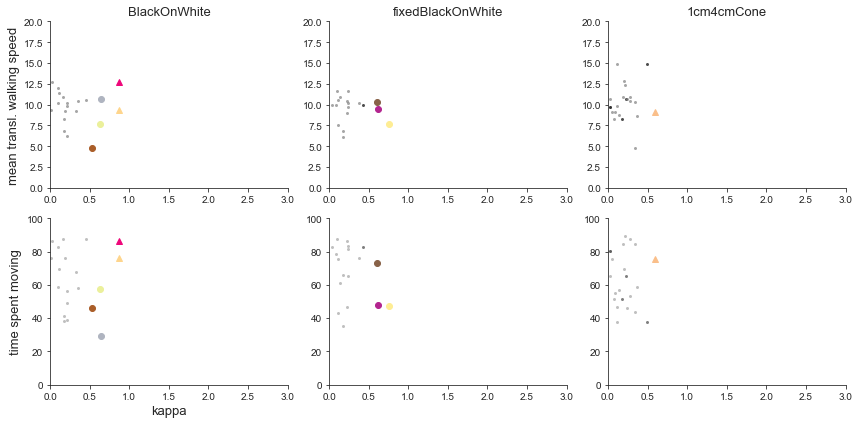

In [165]:
walkingCorr, axs = plt.subplots(2, len(sceneNames), figsize=(12,6))

for scene, sceneName in enumerate(sceneNames):
    print(sceneName)
    
    goodFit = np.logical_and(np.logical_or(vmfits[scene,3,:]>0.1, headingPVA[scene,:,1]>0.5),\
                                  ~np.isnan(headingPVA[scene,:,1]))
    goodFit_bm = vmbmfits[scene,4,:]>0.1

    kappasFly = [vmfits[scene,1,:], vmbmfits[scene,2,:]]
    slct = [np.logical_and(vmfits[scene,1,:]>kappaTH,goodFit),
            np.logical_and(vmbmfits[scene,2,:]>kappaTH,goodFit_bm)]

    markerstyle = [('grey', 'o'), ('black','^')]
    
    for fly in range(numFlies):
        querystring = '(flyID == "' + flyIDs[fly] + '" & sceneName == "'+sceneName+'")'
        scene_df = FOAllFlies_df.query(querystring)
        if len(scene_df)==0 : continue
        if scene_df['trialtype'].values[0] == 'plane':
            scene_df = scene_df.query('LMdist > '+str(minLMdist)+' or LMdist == "NaN"')
            
        flyMov = scene_df['moving'].values.squeeze().astype('int')
        flyVT = scene_df['transVelo'].values.astype('float')

        for i in range(2):
            if(len(kappasFly[i])==0): continue
            if(len(flyMov)==0): continue
            if slct[i][fly]:
                axs[0][scene].plot(kappasFly[i][fly], np.nanmean(flyVT[flyMov>0]), markerstyle[i][1], color=flyCMap.to_rgba(fly))
            else:
                axs[0][scene].plot(kappasFly[i][fly], np.nanmean(flyVT[flyMov>0]), '.',
                                   markerfacecolor=markerstyle[i][0], markeredgecolor='none', alpha=.7)

            if slct[i][fly]:
                axs[1][scene].plot(kappasFly[i][fly], 100.*np.sum(flyMov)/len(flyMov), markerstyle[i][1], color=flyCMap.to_rgba(fly))
            else:
                axs[1][scene].plot(kappasFly[i][fly], 100.*np.sum(flyMov)/len(flyMov), '.', 
                                   markerfacecolor=markerstyle[i][0], markeredgecolor='none', alpha=.5) 

    if not scene:
        axs[0,scene].set_ylabel('mean transl. walking speed', fontsize=13)
        axs[1,scene].set_xlabel('kappa', fontsize=13)
        axs[1,scene].set_ylabel('time spent moving', fontsize=13)
    axs[0,scene].set_xlim(0, 3)
    axs[0,scene].set_ylim(0, 20)
    axs[1,scene].set_xlim(0, 3)
    axs[1,scene].set_ylim(0, 100)
    axs[0,scene].set_title(sceneName, fontsize=13)
    [myAxisTheme(axs[i,scene]) for i in range(2)]
    
walkingCorr.tight_layout()
walkingCorr.savefig(analysisDir + 'velocityTraces'+sep+genotype+'_walkingCorr_n'+ str(numFlies)+'.pdf') 

## Comparison between fixation in 1D and 2D
### Is there a correlation between the location of the fixation peak in 1D and 2D?

1cm4cmCone vs BlackOnWhite


/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/haberkernh/anaconda3/envs/py2.7/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


fixedBlackOnWhite vs BlackOnWhite


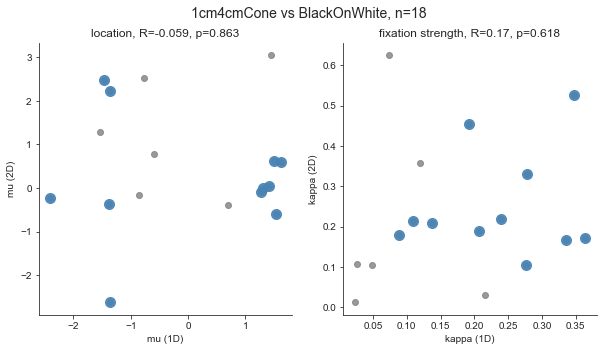

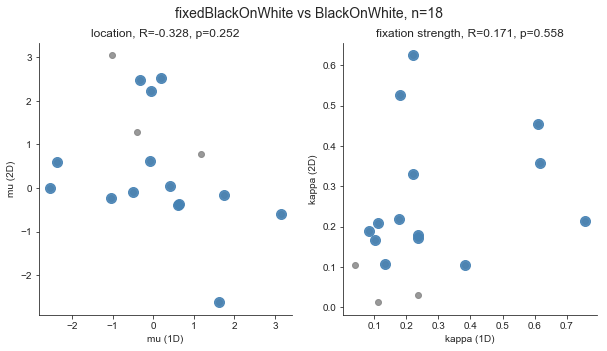

In [166]:
# number of flies with fitted von Mises with Kappa > 0.5 (disregarding also the flies that were not well represented by
# von Mises fit)

groups = [(0,2), (0,1)]

for ind, group in enumerate(groups):
    scene1D = sceneNames[group[1]]
    scene2D = sceneNames[group[0]]
    
    print(scene1D + ' vs ' + scene2D)
    
    #Plot fit results
    fix1Dvs2DFig = plt.figure(figsize=(10,5))
    fix1Dvs2DFig.suptitle(scene1D + ' vs ' + scene2D + ', n='+str(numFlies),fontsize=14)
    
    ## Unimodal
    goodFit1D = np.logical_and(np.logical_or(vmfits[group[1],3,:]>0.1, headingPVA[group[1],:,1]>0.5),\
                              ~np.isnan(headingPVA[group[1],:,1]))
    goodFit2D = np.logical_and(np.logical_or(vmfits[group[0],3,:]>0.1, headingPVA[group[0],:,1]>0.5),\
                              ~np.isnan(headingPVA[group[0],:,1]))
    goodFit = np.logical_and(goodFit1D,goodFit2D)
    
    slct1D = np.logical_and(vmfits[group[1],1,:]>kappaTH,goodFit1D)
    slct2D = np.logical_and(vmfits[group[0],1,:]>kappaTH,goodFit2D)
    slct = np.logical_and(slct1D,slct2D)

    #correlation between fixation location in 1D and 2D
    ax = fix1Dvs2DFig.add_subplot(121)
    ax.plot(vmfits[group[1],0,:],vmfits[group[0],0,:],'o',markersize=6,color='grey',alpha=0.8)
    ax.plot(vmfits[group[1],0,goodFit],vmfits[group[0],0,goodFit],'o',markersize=10,color='steelblue',alpha=0.9)
    ax.plot(vmfits[group[1],0,slct],vmfits[group[0],0,slct],'.',markersize=12,color='tomato',alpha=0.7)
    ax.set_xlabel('mu (1D)')
    ax.set_ylabel('mu (2D)')
    pR, pp = sts.pearsonr(vmfits[group[1],0,goodFit], vmfits[group[0],0,goodFit])
    ax.set_title('location, R='+str(round(pR,3))+', p='+str(round(pp,3)))
    myAxisTheme(ax)
    
    #correlation between fixation strength in 1D and 2D
    ax = fix1Dvs2DFig.add_subplot(122)
    ax.plot(vmfits[group[1],1,:],vmfits[group[0],1,:],'o',markersize=6,color='grey',alpha=0.8)
    ax.plot(vmfits[group[1],1,goodFit],vmfits[group[0],1,goodFit],'o',markersize=10,color='steelblue',alpha=0.9)
    ax.plot(vmfits[group[1],1,slct],vmfits[group[0],1,slct],'.',markersize=12,color='tomato',alpha=0.7)
    ax.set_xlabel('kappa (1D)')
    ax.set_ylabel('kappa (2D)')
    pR, pp = sts.pearsonr(vmfits[group[1],1,goodFit], vmfits[group[0],1,goodFit])
    ax.set_title('fixation strength, R='+str(round(pR,3))+', p='+str(round(pp,3)))
    myAxisTheme(ax)
    
    fix1Dvs2DFig.savefig(analysisDir + 'circStats/'  + genotype + '_' + scene1D + 'Vs' + scene2D
                   + '-Fixation_n'+ str(numFlies) +'.pdf', format='pdf') 

## Intergroup comparison
uses saved data in csv file

In [167]:
analysisDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/lowContrast/stripetracking/comparativeAnalysisofFixation/'
rootDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObj/lowContrast/stripetracking/'

kappaTH = 0.5

def stylePolarPlot(titlestr,ax,sceneYLim,ytickvals,scene):
    ax.set_xticklabels(['0','', r'$\frac{\pi}{2}$','', r'$\pi,-\pi$','', r'$-\frac{\pi}{2}$',''],fontsize=12)
    ax.set_title(titlestr)
    ax.set_rlabel_position(135)
    ax.set_xlim(0, 2*np.pi)
    ax.set_yticks(ytickvals)
    ax.set_ylim(0, sceneYLim[scene])
    ax.axvline(np.pi*(360-120)/360, 0,1, color='dimgrey', linewidth=0.5)
    ax.axvline(-np.pi*(360-120)/360, 0,1, color='dimgrey', linewidth=0.5)
    ax.set_theta_zero_location("N")
    ax.spines['polar'].set_visible(False)

In [185]:
groupName = 'WTBhybrid-highT'
temp = 'highT'
wings = 'cut'
genotype = 'WTBxpDBPGAL4'
ns = [23,18]
sexs = ['female','male']

#sceneNames = ['BlackOnWhite', 'fixedBlackOnWhite', '1cm4cmCone']
sceneDim = ['1D', '1D', '2D']
contrast = ['darkOnBright', 'darkOnBright', 'darkOnBright']
groupCol = ['darkorchid', 'dodgerblue']

In [186]:
genotypes_df = pd.DataFrame()
keylist_gendf = ['genotype', 'group','wings','temp','sex','scene','contrast','sceneName',
               'trialType','flyID','# mu','kappa','gof','mu1_bm','mu2_bm','kappa_bm','gof_bm'] 

for j, scene in enumerate(sceneNames):
    for s, sex in enumerate(sexs):
        path2data = rootDir + groupName + '/1Dv2D_3cond/{}/analysis/circStats/'.format(sex)
        subset_df = pd.read_csv(path2data + '{}_vMFixation_{}_n{}.csv'.format(genotype,scene,ns[s]))

        subset_df.insert(0, 'genotype', genotype)
        subset_df.insert(1, 'group', '{}-{}'.format(temp,wings))
        subset_df.insert(2, 'wings', wings)
        subset_df.insert(3, 'temp', temp)
        subset_df.insert(4, 'sex', sex)
        subset_df.insert(5, 'scene', sceneDim[j])
        subset_df.insert(6, 'contrast', contrast[j])
        subset_df.insert(7, 'sceneName', scene)
        subset_df.insert(8, 'trialType', trialtype)
        subset_df.insert(9, 'flyID', range(len(subset_df)))

        genotypes_df = genotypes_df.append(subset_df)

genotypes_df["genotype"] = genotypes_df["genotype"].astype('category')
genotypes_df["wings"] = genotypes_df["wings"].astype('category')
genotypes_df["temp"] = genotypes_df["temp"].astype('category')
genotypes_df["sex"] = genotypes_df["sex"].astype('category')
genotypes_df["scene"] = genotypes_df["scene"].astype('category')
genotypes_df["contrast"] = genotypes_df["contrast"].astype('category')
genotypes_df["sceneName"] = genotypes_df["sceneName"].astype('category')
genotypes_df["group"] = genotypes_df["group"].astype('category')

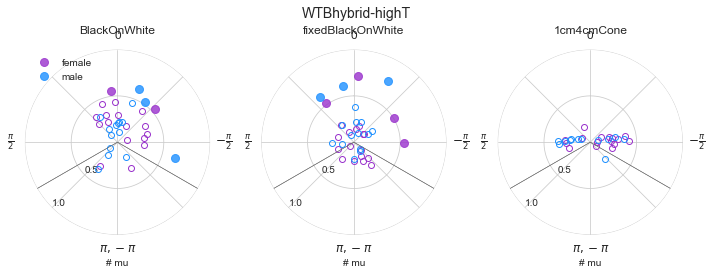

In [192]:
sceneYLim = [1,1,1]
ytickvals = [0.5, 1, 2, 3, 4]
fixFig = plt.figure(figsize=(10,4))
fixFig.suptitle(groupName,fontsize=14)

for scene, sceneName in enumerate(sceneNames):
    #polar plot of fitted location and shape parameter - unimodal
    ax = fixFig.add_subplot(1,3,scene+1, projection='polar')
    for si, sex in enumerate(sexs):
        currdf = genotypes_df.query('sceneName=="{}" & sex=="{}" & genotype=="{}"'.format(sceneName,sex,genotype))
        #notgof_df = currdf.query('gof == 0 & kappa >=0')
        #if not notgof_df.empty:
        #    notgof_df.plot(ax=ax, x="# mu", y="kappa",color='grey', marker='.', alpha=0.6, linestyle='none', grid=True, label='')
            
        gof_df = currdf.query('gof == 1 & kappa < '+str(kappaTH))
        if not gof_df.empty:
            gof_df.plot(ax=ax, x="# mu", y="kappa", color=groupCol[si], marker='o', linestyle='none', 
                       markerfacecolor="None", markeredgewidth=1, markersize=6,grid=True,label='')
            
        fix_df = currdf.query('gof == 1 & kappa >= '+str(kappaTH))
        if not fix_df.empty:
            if scene== 0:
                fix_df.plot(ax=ax, x="# mu", y="kappa", color=groupCol[si], marker='o', markersize=8,
                            alpha=0.8, linestyle='none', grid=True, label=sex)
            else:
                fix_df.plot(ax=ax, x="# mu", y="kappa", color=groupCol[si], marker='o',
                            markersize=8, alpha=0.8, linestyle='none', grid=True, label='')
                               
        stylePolarPlot(sceneName,ax,sceneYLim,ytickvals,scene)
    ax.legend(loc=2, frameon=False)
        
fixFig.tight_layout()
fixFig.savefig(analysisDir+sep+groupName+'_vMFixation_highT-cut_uniModalFixation_3cond.pdf', format='pdf') 

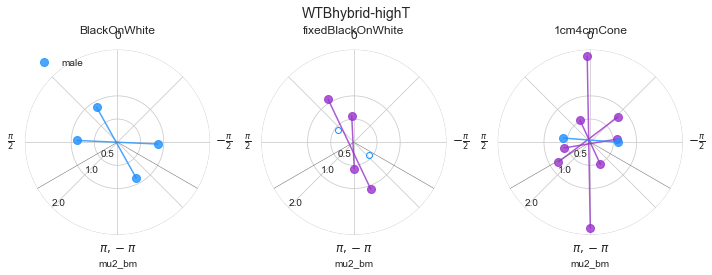

In [193]:
sceneYLim = [2,2,2]
ytickvals = [0.5, 1, 2, 3, 4]

fixFig = plt.figure(figsize=(10,4))
fixFig.suptitle(groupName,fontsize=14)

for scene, sceneName in enumerate(sceneNames):
    #polar plot of fitted location and shape parameter - unimodal
    ax = fixFig.add_subplot(1,3,scene+1, projection='polar')
    for si, sex in enumerate(sexs):
        currdf = genotypes_df.query('sceneName=="{}" & sex=="{}" & genotype=="{}"'.format(sceneName,sex,genotype))
        
        #notgof_df = currdf.query('gof_bm == 0 & kappa_bm >=0')
        #if not notgof_df.empty:
        #    notgof_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", color='grey', marker='.',alpha=0.6, linestyle='none', grid=True, label='')
        #    notgof_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color='grey', marker='.', alpha=0.6, linestyle='none', grid=True, label='')

        gof_df = currdf.query('gof_bm == 1 & kappa_bm < '+str(kappaTH))
        if not gof_df.empty:
            gof_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", markeredgecolor=groupCol[si], marker='o',
                        markerfacecolor='none',  markeredgewidth=1, markersize=6, linestyle='none',grid=True, label='')
            gof_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", markeredgecolor=groupCol[si], marker='o',
                        markerfacecolor='none',  markeredgewidth=1, markersize=6, linestyle='none',grid=True, label='')

        fix_df = currdf.query('gof_bm == 1 & kappa_bm >= '+str(kappaTH))
        if not fix_df.empty:
            try:
                x = [fix_df["mu1_bm"].values, fix_df["mu2_bm"].values]
                y = [fix_df["kappa_bm"].values, fix_df["kappa_bm"].values]
                ax.plot(x,y,alpha=0.8, color=groupCol[si], linewidth=1.5,label='')
            except KeyError:
                print("KeyError " + group)

            fix_df.plot(ax=ax, x="mu1_bm", y="kappa_bm", color=groupCol[si], marker='o',
                        markersize=8, alpha=0.8, linestyle='none', grid=True,label='')
            if scene == 0:
                fix_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color=groupCol[si], marker='o',
                            markersize=8, alpha=0.8, linestyle='none', grid=True,label=sex)
            else:
                fix_df.plot(ax=ax, x="mu2_bm", y="kappa_bm", color=groupCol[si], marker='o',
                            markersize=8, alpha=0.8, linestyle='none', grid=True,label='')

    stylePolarPlot(sceneName,ax,sceneYLim,ytickvals,scene)
    ax.legend(loc=2, frameon=False)        
fixFig.tight_layout()
fixFig.savefig(analysisDir+sep+groupName+'_vMFixation_highT-cut_biModalFixation_3cond.pdf', format='pdf') 